In [1]:
import argparse
import os
import glob

#load data
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torchvision import transforms, utils, datasets

from PIL import Image
import torch
from torch import nn
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import SYNet
import time
import copy
import csv

In [2]:
concrete_cement_type = [1.0, 0.0, 0.0, 0.0, 0.0]
healthy_metal_type = [0.0, 1.0, 0.0, 0.0, 0.0]
incomplete_type = [0.0, 0.0, 1.0, 0.0, 0.0]
irregular_metal_type = [0.0, 0.0, 0.0, 1.0, 0.0]
other_type = [0.0, 0.0, 0.0, 0.0, 1.0]

In [3]:
concrete_cement_images = glob.glob('./training/unmasked/concrete_cement/*.png')
a= [concrete_cement_type] * len(concrete_cement_images)

healthy_metal_images = glob.glob('./training/masked/healthy_metal/*.png')
b=[healthy_metal_type] * len(healthy_metal_images)

incomplete_images = glob.glob('./training/masked/incomplete/*.png')
c=[incomplete_type] * len(incomplete_images)

irregular_metal_images = glob.glob('./training/masked/irregular_metal/*.png')
d=[irregular_metal_type]  * len(irregular_metal_images)

other_images = glob.glob('./training/masked/other/*.png')
e=[other_type] * len(other_images)

train_images = [concrete_cement_images, healthy_metal_images, incomplete_images, irregular_metal_images, other_images]
train_images_labels = [a,b,c,d,e]

train_images = [item for sublist in train_images for item in sublist]
train_images_labels = [item for sublist in train_images_labels for item in sublist]

test_images = glob.glob('./testing/masked/*.png')

In [4]:
test_images[0]

'./testing/masked/7a473fca.png'

In [5]:
class RoofDataset(Dataset):
    def __init__(self, train_image_paths, train_images_labels,transform=None):
        self.image_paths = train_image_paths
        self.image_labels = train_images_labels
        self.transform=transform
        
    def __getitem__(self, index):
        roof_image = Image.open(self.image_paths[index])
        roof_image = roof_image.convert('RGB')
        plt.imshow(roof_image)
        if self.transform is not None:
            roof_image = self.transform(roof_image)
        
        material_type = torch.LongTensor(self.image_labels[index])
        return roof_image, material_type    
    
    def __len__(self):
        return len(self.image_paths)

In [6]:
class RoofTestDataset(Dataset):
    def __init__(self, image_paths,transform=None):
        self.image_paths = image_paths
        self.transform=transform
        
    def __getitem__(self, index):
        roof_id = self.image_paths[index].replace('./testing/masked/','').replace('.png','')
        print("Replaced:", roof_id)
        roof_image = Image.open(self.image_paths[index])
        roof_image = roof_image.convert('RGB')
        plt.imshow(roof_image)
        if self.transform is not None:
            roof_image = self.transform(roof_image)
        return roof_image, roof_id
    
    def __len__(self):
        return len(self.image_paths)

In [7]:
transformations = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
train_dataset = RoofDataset(train_images, train_images_labels,transformations)

train_loader = DataLoader(train_dataset,
                          batch_size=32,
                          shuffle=True,
                          num_workers=0
                         )

test_dataset = RoofTestDataset(test_images, transformations)
test_loader = DataLoader(test_dataset,
                        batch_size = 1,
                        num_workers = 0)

In [8]:
model = SYNet.Baseline()
model.cuda()
raise
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.5)
#criterion = torch.nn.functional.softmax(output)
criterion = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(async=True), target.cuda(async=True) # On GPU
        #data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        _, idx = torch.max(target,1)
        loss = criterion(output, idx)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))

for epoch in range(1,6):
    train(epoch)

RuntimeError: No active exception to reraise

### torch.save(model.state_dict(), './models/resnet18_5_0.0001.pt')

In [9]:
model.load_state_dict(torch.load('./models/resnet18_5_0.0001.pt'))

<All keys matched successfully>

Replaced: 7a473fca
7a473fca
7a473fca [[0.02517179399728775, 0.4709436297416687, 0.03457389399409294, 0.4544205367565155, 0.014890111051499844]]
Replaced: 7a4f3a36
7a4f3a36
7a4f3a36 [[0.001729584764689207, 0.8979650139808655, 0.01116366870701313, 0.08332790434360504, 0.005813831929117441]]
Replaced: 7a4b71f8
7a4b71f8
7a4b71f8 [[0.0685456171631813, 0.6466475129127502, 0.03782617300748825, 0.23505964875221252, 0.01192106306552887]]
Replaced: 7a48f2fc
7a48f2fc
7a48f2fc [[0.004646842833608389, 0.3153732419013977, 0.042762383818626404, 0.6258679032325745, 0.011349627748131752]]
Replaced: 7a50aba0
7a50aba0
7a50aba0 [[0.3543044924736023, 0.08379912376403809, 0.09859064221382141, 0.44461941719055176, 0.01868630200624466]]
Replaced: 7a48eabe
7a48eabe
7a48eabe [[0.025029465556144714, 0.5456451773643494, 0.07269051671028137, 0.3415814936161041, 0.015053275972604752]]
Replaced: 7a47a988
7a47a988
7a47a988 [[0.0027350604068487883, 0.8190363645553589, 0.010509765706956387, 0.16215598583221436, 0.00556

7a500e70
7a500e70 [[0.05070863664150238, 0.37881729006767273, 0.06004856154322624, 0.5008315443992615, 0.009593941271305084]]
Replaced: 7a4974d4
7a4974d4
7a4974d4 [[0.0043722582049667835, 0.19233740866184235, 0.04746297374367714, 0.7488411068916321, 0.0069862063974142075]]
Replaced: 7a4ebe30
7a4ebe30
7a4ebe30 [[0.0013795143458992243, 0.9328330755233765, 0.00657673692330718, 0.05626055970788002, 0.0029499803204089403]]
Replaced: 7a516d24
7a516d24
7a516d24 [[0.059224020689725876, 0.22305555641651154, 0.25744131207466125, 0.4294033646583557, 0.030875805765390396]]
Replaced: 7a4df0ea
7a4df0ea
7a4df0ea [[0.006245403550565243, 0.7151141166687012, 0.016400538384914398, 0.2579531669616699, 0.004286759998649359]]
Replaced: 7a4fa340
7a4fa340
7a4fa340 [[0.0012524983612820506, 0.9549261331558228, 0.009728719480335712, 0.030467141419649124, 0.0036254895385354757]]
Replaced: 7a4f78f2
7a4f78f2
7a4f78f2 [[0.004894999787211418, 0.7583538889884949, 0.029292266815900803, 0.1957835555076599, 0.01167530007

7a50b6f4
7a50b6f4 [[0.01494891382753849, 0.760419487953186, 0.023645669221878052, 0.19507645070552826, 0.005909453146159649]]
Replaced: 7a51749a
7a51749a
7a51749a [[0.0010448343819007277, 0.9167457818984985, 0.0046885632909834385, 0.0724402368068695, 0.0050806947983801365]]
Replaced: 7a47475e
7a47475e
7a47475e [[0.025327254086732864, 0.7270483374595642, 0.03775695338845253, 0.191999614238739, 0.0178677961230278]]
Replaced: 7a4ba47a
7a4ba47a
7a4ba47a [[0.004899198655039072, 0.8465662598609924, 0.012958003208041191, 0.12689678370952606, 0.008679735474288464]]
Replaced: 7a4670ae
7a4670ae
7a4670ae [[0.00151261396240443, 0.9374071359634399, 0.006933664437383413, 0.05055830255150795, 0.0035882226657122374]]
Replaced: 7a4d0c34
7a4d0c34
7a4d0c34 [[0.004906950052827597, 0.47996026277542114, 0.06836725026369095, 0.43874669075012207, 0.008018840104341507]]
Replaced: 7a482fca
7a482fca
7a482fca [[0.015618272125720978, 0.18175292015075684, 0.10969538986682892, 0.6591482758522034, 0.0337851345539093]

7a4add92 [[0.006630952004343271, 0.27293452620506287, 0.049874793738126755, 0.6579456329345703, 0.012614106759428978]]
Replaced: 7a4c1720
7a4c1720
7a4c1720 [[0.006878098007291555, 0.475845068693161, 0.05678579583764076, 0.4498385488986969, 0.010652519762516022]]
Replaced: 7a4b57fe
7a4b57fe
7a4b57fe [[0.03556298837065697, 0.2670457363128662, 0.09999064356088638, 0.5808725953102112, 0.016527986153960228]]
Replaced: 7a476e8c
7a476e8c
7a476e8c [[0.008714716881513596, 0.8064020872116089, 0.02160543017089367, 0.13830314576625824, 0.024974659085273743]]
Replaced: 7a4a8d24
7a4a8d24
7a4a8d24 [[0.0038200877606868744, 0.8703253269195557, 0.010795053094625473, 0.10091178119182587, 0.014147676527500153]]
Replaced: 7a5132e6
7a5132e6
7a5132e6 [[0.005006582476198673, 0.23663856089115143, 0.026308340951800346, 0.7232010364532471, 0.008845392614603043]]
Replaced: 7a4dc322
7a4dc322
7a4dc322 [[0.012337198480963707, 0.6480954885482788, 0.03542688488960266, 0.29606443643569946, 0.008075946010649204]]
Replac

7a45e166 [[0.03052695281803608, 0.520311713218689, 0.048390887677669525, 0.3902142345905304, 0.010556215420365334]]
Replaced: 7a48bae4
7a48bae4
7a48bae4 [[0.005538997706025839, 0.28364649415016174, 0.03809348866343498, 0.6582636833190918, 0.014457374811172485]]
Replaced: 7a4e8cee
7a4e8cee
7a4e8cee [[0.03727253898978233, 0.3202030658721924, 0.07602659612894058, 0.550360381603241, 0.016137462109327316]]
Replaced: 7a4cc5d0
7a4cc5d0
7a4cc5d0 [[0.020327609032392502, 0.43465474247932434, 0.046461787074804306, 0.4884108006954193, 0.010145002976059914]]
Replaced: 7a4d7f16
7a4d7f16
7a4d7f16 [[0.003092101076617837, 0.9331782460212708, 0.006175288464874029, 0.055525362491607666, 0.0020290198735892773]]
Replaced: 7a511db0
7a511db0
7a511db0 [[0.0007691971841268241, 0.9622088670730591, 0.005239114630967379, 0.029089001938700676, 0.0026938640512526035]]
Replaced: 7a509f70
7a509f70
7a509f70 [[0.0007236800738610327, 0.9822036027908325, 0.006455924361944199, 0.0094706229865551, 0.0011461087269708514]]
R

7a4f582c
7a4f582c [[0.33777502179145813, 0.07746010273694992, 0.1630764901638031, 0.41595277190208435, 0.0057356031611561775]]
Replaced: 7a4746a0
7a4746a0
7a4746a0 [[0.03783208131790161, 0.05917176976799965, 0.04589950665831566, 0.8516614437103271, 0.005435231141746044]]
Replaced: 7a4d424e
7a4d424e
7a4d424e [[0.0818183571100235, 0.1719432920217514, 0.154037743806839, 0.5666861534118652, 0.02551446296274662]]
Replaced: 7a4d3952
7a4d3952
7a4d3952 [[0.005905613303184509, 0.09334755688905716, 0.050550807267427444, 0.8437175750732422, 0.006478418596088886]]
Replaced: 7a4ebae8
7a4ebae8
7a4ebae8 [[0.06510091572999954, 0.646103024482727, 0.0545191690325737, 0.21489547193050385, 0.019381415098905563]]
Replaced: 7a4c52a8
7a4c52a8
7a4c52a8 [[0.004897205159068108, 0.8647953271865845, 0.01712333783507347, 0.10345561802387238, 0.009728487581014633]]
Replaced: 7a4b39a4
7a4b39a4
7a4b39a4 [[0.0006973783602006733, 0.9312294721603394, 0.0021127115469425917, 0.06351015716791153, 0.00245031644590199]]
Repl

7a4f1c40
7a4f1c40 [[0.0031067749951034784, 0.928439199924469, 0.012733536772429943, 0.05066783353686333, 0.00505264475941658]]
Replaced: 7a50a9a2
7a50a9a2
7a50a9a2 [[0.007571749854832888, 0.7546713352203369, 0.027512235566973686, 0.19942298531532288, 0.010821652598679066]]
Replaced: 7a4e916c
7a4e916c
7a4e916c [[0.0006686262204311788, 0.9830743670463562, 0.004076564218848944, 0.010775763541460037, 0.001404720125719905]]
Replaced: 7a4806d0
7a4806d0
7a4806d0 [[0.00045191720710135996, 0.9667173027992249, 0.008637931197881699, 0.020615531131625175, 0.0035773091949522495]]
Replaced: 7a4aa368
7a4aa368
7a4aa368 [[0.0009314151247963309, 0.8048548102378845, 0.010395895689725876, 0.18180955946445465, 0.002008316107094288]]
Replaced: 7a49e4b4
7a49e4b4
7a49e4b4 [[0.007870327681303024, 0.6422855257987976, 0.0502440482378006, 0.2921443581581116, 0.007455770391970873]]
Replaced: 7a495d6e
7a495d6e
7a495d6e [[0.18168814480304718, 0.09798043966293335, 0.10633567720651627, 0.5914530158042908, 0.0225427206

7a4fce06 [[0.005701589863747358, 0.29430243372917175, 0.08585844188928604, 0.6040393710136414, 0.010098159313201904]]
Replaced: 7a46449e
7a46449e
7a46449e [[0.0074524180963635445, 0.4743417203426361, 0.0287628173828125, 0.48258110880851746, 0.006861990783363581]]
Replaced: 7a487a16
7a487a16
7a487a16 [[0.011628114618360996, 0.009054901078343391, 0.0352354496717453, 0.9415935277938843, 0.002487949561327696]]
Replaced: 7a4882cc
7a4882cc
7a4882cc [[0.011557139456272125, 0.252855122089386, 0.018234286457300186, 0.7152532935142517, 0.0021001470740884542]]
Replaced: 7a5116a8
7a5116a8
7a5116a8 [[0.0007893898873589933, 0.9419479370117188, 0.00512435007840395, 0.0507717989385128, 0.0013664717553183436]]
Replaced: 7a4b638e
7a4b638e
7a4b638e [[0.009219110012054443, 0.2192145138978958, 0.045927196741104126, 0.7186813950538635, 0.006957814563065767]]
Replaced: 7a4a2118
7a4a2118
7a4a2118 [[0.0034410625230520964, 0.9084054827690125, 0.0033397451043128967, 0.083603136241436, 0.0012106355279684067]]
Rep

7a4dbe22
7a4dbe22 [[0.21249821782112122, 0.04259636998176575, 0.20305092632770538, 0.5203127264976501, 0.021541768684983253]]
Replaced: 7a4cdbf6
7a4cdbf6
7a4cdbf6 [[0.008448543958365917, 0.87080979347229, 0.02617708034813404, 0.08656194806098938, 0.008002675138413906]]
Replaced: 7a4c6806
7a4c6806
7a4c6806 [[0.005450105760246515, 0.8227735161781311, 0.01998116821050644, 0.14242030680179596, 0.009374876506626606]]
Replaced: 7a472e18
7a472e18
7a472e18 [[0.07371757924556732, 0.4965325593948364, 0.044275760650634766, 0.36548006534576416, 0.019993970170617104]]
Replaced: 7a502504
7a502504
7a502504 [[0.01375660765916109, 0.8902354836463928, 0.019258439540863037, 0.06914149224758148, 0.00760797830298543]]
Replaced: 7a476c34
7a476c34
7a476c34 [[0.012406662106513977, 0.007825608365237713, 0.020841406658291817, 0.9556604623794556, 0.00326584093272686]]
Replaced: 7a48df88
7a48df88
7a48df88 [[0.07161325961351395, 0.09296149015426636, 0.11216633021831512, 0.7144761681556702, 0.008782743476331234]]
R

7a4a2cee [[0.017658015713095665, 0.13781233131885529, 0.05354611948132515, 0.750256359577179, 0.040727194398641586]]
Replaced: 7a495954
7a495954
7a495954 [[0.0021042933221906424, 0.8316318988800049, 0.025779595598578453, 0.1334829181432724, 0.007001306861639023]]
Replaced: 7a50aa6a
7a50aa6a
7a50aa6a [[0.006273712497204542, 0.6750404238700867, 0.019337482750415802, 0.289039671421051, 0.010308648459613323]]
Replaced: 7a49ce2a
7a49ce2a
7a49ce2a [[0.00757537130266428, 0.8498919010162354, 0.02526090294122696, 0.10690977424383163, 0.010362034663558006]]
Replaced: 7a4d5d60
7a4d5d60
7a4d5d60 [[0.034233011305332184, 0.16021135449409485, 0.06226274371147156, 0.7309361696243286, 0.012356688268482685]]
Replaced: 7a47ad20
7a47ad20
7a47ad20 [[0.04173232242465019, 0.18349434435367584, 0.0205889530479908, 0.7418145537376404, 0.012369826436042786]]
Replaced: 7a4edf50
7a4edf50
7a4edf50 [[0.018198110163211823, 0.3270133137702942, 0.12077585607767105, 0.5230662226676941, 0.010946514084935188]]
Replaced: 7

7a50f5d8 [[0.00034957603202201426, 0.9782002568244934, 0.004788381978869438, 0.014923390932381153, 0.0017384429229423404]]
Replaced: 7a4b197e
7a4b197e
7a4b197e [[0.009601599536836147, 0.4517257809638977, 0.030853724107146263, 0.4981781244277954, 0.009640783071517944]]
Replaced: 7a50cc34
7a50cc34
7a50cc34 [[0.02332605980336666, 0.7525755167007446, 0.021387524902820587, 0.19092190265655518, 0.0117889903485775]]
Replaced: 7a4bea34
7a4bea34
7a4bea34 [[0.0053586941212415695, 0.7237297892570496, 0.01506086066365242, 0.24820531904697418, 0.007645400241017342]]
Replaced: 7a4f0ec6
7a4f0ec6
7a4f0ec6 [[0.05944979190826416, 0.5147917866706848, 0.04907777160406113, 0.3524473309516907, 0.02423332817852497]]
Replaced: 7a4de1b8
7a4de1b8
7a4de1b8 [[0.0018944175681099296, 0.39590615034103394, 0.02828516624867916, 0.5662103295326233, 0.007703941315412521]]
Replaced: 7a4e20d8
7a4e20d8
7a4e20d8 [[0.004933645948767662, 0.900947630405426, 0.013462169095873833, 0.0774674043059349, 0.0031891914550215006]]
Repl

7a46999e
7a46999e [[0.011380635201931, 0.14919790625572205, 0.019863186404109, 0.8152788877487183, 0.004279476124793291]]
Replaced: 7a4ce0e2
7a4ce0e2
7a4ce0e2 [[0.11898364126682281, 0.191313236951828, 0.13980887830257416, 0.5379040837287903, 0.011990177445113659]]
Replaced: 7a4c3f20
7a4c3f20
7a4c3f20 [[0.0017567651811987162, 0.8741908669471741, 0.009694384410977364, 0.10996363312005997, 0.004394305404275656]]
Replaced: 7a49a85a
7a49a85a
7a49a85a [[0.10666662454605103, 0.25025269389152527, 0.0465007945895195, 0.5689773559570312, 0.02760249376296997]]
Replaced: 7a50520e
7a50520e
7a50520e [[0.00829134602099657, 0.569974422454834, 0.06414376199245453, 0.3327467143535614, 0.024843713268637657]]
Replaced: 7a4fb7a4
7a4fb7a4
7a4fb7a4 [[0.016334593296051025, 0.23652422428131104, 0.09878406673669815, 0.6405549645423889, 0.007802124135196209]]
Replaced: 7a51a8de
7a51a8de
7a51a8de [[0.0019947895780205727, 0.89699387550354, 0.009390495717525482, 0.08903351426124573, 0.0025872078258544207]]
Replaced

7a4de42e [[0.012763182632625103, 0.3332538902759552, 0.054374292492866516, 0.5874858498573303, 0.01212275680154562]]
Replaced: 7a4ef3aa
7a4ef3aa
7a4ef3aa [[0.01800629124045372, 0.8700975775718689, 0.018086636438965797, 0.08831880986690521, 0.005490782670676708]]
Replaced: 7a4d359c
7a4d359c
7a4d359c [[0.003970991354435682, 0.06554652750492096, 0.01820347271859646, 0.9099529981613159, 0.0023259506560862064]]
Replaced: 7a482f66
7a482f66
7a482f66 [[0.1586071103811264, 0.2532706558704376, 0.10345184803009033, 0.4728485643863678, 0.011821884661912918]]
Replaced: 7a4fadd6
7a4fadd6
7a4fadd6 [[0.0182819664478302, 0.3500494658946991, 0.04659901186823845, 0.5723531246185303, 0.012716352008283138]]
Replaced: 7a4c993e
7a4c993e
7a4c993e [[0.008156967349350452, 0.4740484058856964, 0.1202014684677124, 0.38714566826820374, 0.010447505861520767]]
Replaced: 7a4d25ac
7a4d25ac
7a4d25ac [[0.01196733582764864, 0.15423905849456787, 0.043190717697143555, 0.7849198579788208, 0.005683085881173611]]
Replaced: 7a5

7a48ae5a
7a48ae5a [[0.10220526903867722, 0.10814942419528961, 0.13096943497657776, 0.6348944306373596, 0.023781489580869675]]
Replaced: 7a47df5c
7a47df5c
7a47df5c [[0.0042335656471550465, 0.7654334306716919, 0.013091063126921654, 0.21368266642093658, 0.003559269942343235]]
Replaced: 7a4bba32
7a4bba32
7a4bba32 [[0.047362715005874634, 0.4122721552848816, 0.12007192522287369, 0.396979957818985, 0.023313233628869057]]
Replaced: 7a4f512e
7a4f512e
7a4f512e [[0.00141533138230443, 0.9688413143157959, 0.005798748228698969, 0.021272258833050728, 0.002672247588634491]]
Replaced: 7a4cf898
7a4cf898
7a4cf898 [[0.02565951459109783, 0.3030168116092682, 0.04572846367955208, 0.6171356439590454, 0.008459596894681454]]
Replaced: 7a48fe1e
7a48fe1e
7a48fe1e [[0.014290455728769302, 0.9130375385284424, 0.017945721745491028, 0.043653566390275955, 0.011072752065956593]]
Replaced: 7a461064
7a461064
7a461064 [[0.000252778670983389, 0.9852044582366943, 0.0019525650423020124, 0.01062239333987236, 0.0019679025281220

7a512404
7a512404 [[0.021494947373867035, 0.49900907278060913, 0.038765255361795425, 0.42534011602401733, 0.015390604734420776]]
Replaced: 7a47a276
7a47a276
7a47a276 [[0.006161109544336796, 0.04731927812099457, 0.04526502266526222, 0.8944217562675476, 0.006832876708358526]]
Replaced: 7a50fd30
7a50fd30
7a50fd30 [[0.0013750470243394375, 0.8903047442436218, 0.006420312914997339, 0.0981554463505745, 0.003744423156604171]]
Replaced: 7a47fd20
7a47fd20
7a47fd20 [[0.017529400065541267, 0.5707793831825256, 0.053285304456949234, 0.34125635027885437, 0.017149601131677628]]
Replaced: 7a49a580
7a49a580
7a49a580 [[0.008844553492963314, 0.5758843421936035, 0.07437770813703537, 0.3264765739440918, 0.014416821300983429]]
Replaced: 7a4f971a
7a4f971a
7a4f971a [[0.0007075415342114866, 0.9139501452445984, 0.005999292246997356, 0.07774533331394196, 0.0015977268340066075]]
Replaced: 7a4e13b8
7a4e13b8
7a4e13b8 [[0.03135223686695099, 0.6561194658279419, 0.028232311829924583, 0.26892855763435364, 0.015367409214

Replaced: 7a4bbaa0
7a4bbaa0
7a4bbaa0 [[0.03280051052570343, 0.47364670038223267, 0.0457642525434494, 0.41934967041015625, 0.02843884937465191]]
Replaced: 7a492b00
7a492b00
7a492b00 [[0.0013269606279209256, 0.963707685470581, 0.004643418826162815, 0.028082653880119324, 0.0022392538376152515]]
Replaced: 7a4b8f3a
7a4b8f3a
7a4b8f3a [[0.011301819235086441, 0.8253501653671265, 0.031407080590724945, 0.10553540289402008, 0.026405535638332367]]
Replaced: 7a495256
7a495256
7a495256 [[0.01885181851685047, 0.28856244683265686, 0.02698085643351078, 0.6358996033668518, 0.02970534935593605]]
Replaced: 7a51a500
7a51a500
7a51a500 [[0.0002193712571170181, 0.9444440603256226, 0.0014620574656873941, 0.052586257457733154, 0.001288278610445559]]
Replaced: 7a515488
7a515488
7a515488 [[0.019120294600725174, 0.02121659182012081, 0.03261604905128479, 0.9238170385360718, 0.0032300101593136787]]
Replaced: 7a5074be
7a5074be
7a5074be [[0.0036518226843327284, 0.8278045654296875, 0.009311065077781677, 0.1557877808809

7a49f04e
7a49f04e [[0.001878273906186223, 0.932888925075531, 0.008164744824171066, 0.05255633592605591, 0.004511644132435322]]
Replaced: 7a4808a6
7a4808a6
7a4808a6 [[0.11320972442626953, 0.3785875141620636, 0.10700240731239319, 0.3682790696620941, 0.03292128071188927]]
Replaced: 7a51756c
7a51756c
7a51756c [[0.02132522687315941, 0.16719961166381836, 0.07536181807518005, 0.7183110117912292, 0.01780231110751629]]
Replaced: 7a4cdfa2
7a4cdfa2
7a4cdfa2 [[0.015261423774063587, 0.281003475189209, 0.06343827396631241, 0.6235771775245667, 0.016719616949558258]]
Replaced: 7a4d121a
7a4d121a
7a4d121a [[0.06072783097624779, 0.17994770407676697, 0.21547235548496246, 0.527401328086853, 0.01645077019929886]]
Replaced: 7a49074c
7a49074c
7a49074c [[0.024188604205846786, 0.3299611806869507, 0.04992923140525818, 0.5778825879096985, 0.018038377165794373]]
Replaced: 7a4b63fc
7a4b63fc
7a4b63fc [[0.0006219760980457067, 0.9225642085075378, 0.010652641765773296, 0.06419000774621964, 0.001971124205738306]]
Replac

7a4e7f10
7a4e7f10 [[0.004576992709189653, 0.47554394602775574, 0.035407185554504395, 0.47816896438598633, 0.0063028824515640736]]
Replaced: 7a473ca0
7a473ca0
7a473ca0 [[0.21105656027793884, 0.03861071914434433, 0.08928387612104416, 0.6385137438774109, 0.022535119205713272]]
Replaced: 7a510e06
7a510e06
7a510e06 [[0.0031828847713768482, 0.9584437012672424, 0.0037711586337536573, 0.03173823654651642, 0.0028639831580221653]]
Replaced: 7a4cb568
7a4cb568
7a4cb568 [[0.015324249863624573, 0.22862303256988525, 0.06947451829910278, 0.670935869216919, 0.01564233936369419]]
Replaced: 7a45b182
7a45b182
7a45b182 [[0.018489977344870567, 0.2624920606613159, 0.04722443222999573, 0.6590957641601562, 0.012697752565145493]]
Replaced: 7a49a4ae
7a49a4ae
7a49a4ae [[0.46549344062805176, 0.03324776887893677, 0.16363677382469177, 0.32319650053977966, 0.014425513334572315]]
Replaced: 7a45bbfa
7a45bbfa
7a45bbfa [[0.019076431170105934, 0.30012375116348267, 0.058740515261888504, 0.5996749401092529, 0.02238441444933

7a4b969c [[0.001790741691365838, 0.8038550615310669, 0.0068297311663627625, 0.18440461158752441, 0.0031198717188090086]]
Replaced: 7a4fafe8
7a4fafe8
7a4fafe8 [[0.015586336143314838, 0.5107208490371704, 0.0343901664018631, 0.4044526517391205, 0.03484999015927315]]
Replaced: 7a46a7b8
7a46a7b8
7a46a7b8 [[0.0004774890257976949, 0.8830187916755676, 0.005767263006418943, 0.10922398418188095, 0.0015124819474294782]]
Replaced: 7a4c6c2a
7a4c6c2a
7a4c6c2a [[0.0005865004495717585, 0.9665006399154663, 0.0036117108538746834, 0.026238055899739265, 0.003063017036765814]]
Replaced: 7a4bc6ee
7a4bc6ee
7a4bc6ee [[0.013949607498943806, 0.4568481743335724, 0.09506437927484512, 0.41714271903038025, 0.016995105892419815]]
Replaced: 7a454f30
7a454f30
7a454f30 [[0.05882079899311066, 0.46591052412986755, 0.11469423770904541, 0.3336865305900574, 0.026887934654951096]]
Replaced: 7a499e0a
7a499e0a
7a499e0a [[0.0142609728500247, 0.043776512145996094, 0.07449860125780106, 0.8571783304214478, 0.010285535827279091]]
R

7a4a42c4
7a4a42c4 [[0.06888074427843094, 0.45181456208229065, 0.065645731985569, 0.4059516191482544, 0.0077073173597455025]]
Replaced: 7a4b694c
7a4b694c
7a4b694c [[0.03619809448719025, 0.26046279072761536, 0.06903167814016342, 0.609711766242981, 0.024595677852630615]]
Replaced: 7a4dcf98
7a4dcf98
7a4dcf98 [[0.03923334181308746, 0.23585878312587738, 0.036360546946525574, 0.6811720132827759, 0.007375325541943312]]
Replaced: 7a47e01a
7a47e01a
7a47e01a [[0.011452495120465755, 0.7320082187652588, 0.03402867168188095, 0.21071629226207733, 0.011794301681220531]]
Replaced: 7a51bc5c
7a51bc5c
7a51bc5c [[0.003240492893382907, 0.7695634365081787, 0.012889913283288479, 0.20488320291042328, 0.009422941133379936]]
Replaced: 7a466a6e
7a466a6e
7a466a6e [[0.009162615053355694, 0.6343010067939758, 0.014107277616858482, 0.33796170353889465, 0.004467329476028681]]
Replaced: 7a510ac8
7a510ac8
7a510ac8 [[0.0022068589460104704, 0.9270115494728088, 0.005971344653517008, 0.06285881251096725, 0.001951387268491089

7a4fe440 [[0.037602368742227554, 0.18919877707958221, 0.11440988630056381, 0.6508477330207825, 0.007941203191876411]]
Replaced: 7a4f77bc
7a4f77bc
7a4f77bc [[0.0008178624557331204, 0.9361762404441833, 0.005991749931126833, 0.05464939400553703, 0.0023647090420126915]]
Replaced: 7a493a8c
7a493a8c
7a493a8c [[0.047264572232961655, 0.7983709573745728, 0.032862477004528046, 0.0989985466003418, 0.02250346727669239]]
Replaced: 7a4bb190
7a4bb190
7a4bb190 [[0.010778832249343395, 0.10648004710674286, 0.08000756800174713, 0.7942198514938354, 0.00851372443139553]]
Replaced: 7a4de500
7a4de500
7a4de500 [[0.06260916590690613, 0.09736169874668121, 0.06682536751031876, 0.756646454334259, 0.016557376831769943]]
Replaced: 7a4c0a78
7a4c0a78
7a4c0a78 [[0.002781182760372758, 0.9511327743530273, 0.005767847411334515, 0.03497803211212158, 0.005340156145393848]]
Replaced: 7a4b8328
7a4b8328
7a4b8328 [[0.04320959374308586, 0.2604982852935791, 0.1508793830871582, 0.515426516532898, 0.029986286535859108]]
Replaced: 

7a505be6 [[0.0371273048222065, 0.027585001662373543, 0.10812276601791382, 0.8141143321990967, 0.013050577603280544]]
Replaced: 7a4b9ab6
7a4b9ab6
7a4b9ab6 [[0.03777499124407768, 0.40860140323638916, 0.16367751359939575, 0.3470849096775055, 0.042861197143793106]]
Replaced: 7a4691ce
7a4691ce
7a4691ce [[0.005758566781878471, 0.7866210341453552, 0.016201268881559372, 0.18562570214271545, 0.005793349351733923]]
Replaced: 7a4cd296
7a4cd296
7a4cd296 [[0.039873503148555756, 0.13096952438354492, 0.15161389112472534, 0.6088289022445679, 0.06871416419744492]]
Replaced: 7a4e5684
7a4e5684
7a4e5684 [[0.004249993711709976, 0.3853624761104584, 0.059137750416994095, 0.5426476001739502, 0.008602162823081017]]
Replaced: 7a4f44ea
7a4f44ea
7a4f44ea [[0.011051027104258537, 0.1272691786289215, 0.12407515197992325, 0.720493495464325, 0.017111098393797874]]
Replaced: 7a4e8f5a
7a4e8f5a
7a4e8f5a [[0.2280738651752472, 0.03988680988550186, 0.3161536455154419, 0.3956398665904999, 0.020245755091309547]]
Replaced: 7a4

7a48672e
7a48672e [[0.0015924781328067183, 0.8965142965316772, 0.00943206250667572, 0.0876217782497406, 0.00483934860676527]]
Replaced: 7a4b1ece
7a4b1ece
7a4b1ece [[0.029466228559613228, 0.14770476520061493, 0.07342582195997238, 0.7410424947738647, 0.008360722102224827]]
Replaced: 7a4e9374
7a4e9374
7a4e9374 [[0.0037848635111004114, 0.9039780497550964, 0.011715426109731197, 0.06956709176301956, 0.010954607278108597]]
Replaced: 7a48c9c6
7a48c9c6
7a48c9c6 [[0.004053726326674223, 0.6031803488731384, 0.025497697293758392, 0.3608536124229431, 0.006414594128727913]]
Replaced: 7a4e86cc
7a4e86cc
7a4e86cc [[0.01242227852344513, 0.6755041480064392, 0.03910605609416962, 0.2636469304561615, 0.009320605546236038]]
Replaced: 7a45d9fa
7a45d9fa
7a45d9fa [[0.009553533978760242, 0.6296923160552979, 0.018506139516830444, 0.32681724429130554, 0.015430765226483345]]
Replaced: 7a48f28e
7a48f28e
7a48f28e [[0.0019543212838470936, 0.9604015350341797, 0.00957627035677433, 0.023813417181372643, 0.0042544701136648

7a4bdb7a [[0.005678166635334492, 0.7012045383453369, 0.010713852941989899, 0.2790367007255554, 0.0033667334355413914]]
Replaced: 7a4692a0
7a4692a0
7a4692a0 [[0.037054795771837234, 0.0852261632680893, 0.0619952566921711, 0.800111711025238, 0.015612156130373478]]
Replaced: 7a491b88
7a491b88
7a491b88 [[0.026683349162340164, 0.07674309611320496, 0.04743059724569321, 0.8392841219902039, 0.00985877774655819]]
Replaced: 7a482b9c
7a482b9c
7a482b9c [[0.05641428753733635, 0.310362309217453, 0.058882344514131546, 0.5619134902954102, 0.012427577748894691]]
Replaced: 7a4f2528
7a4f2528
7a4f2528 [[0.10622045397758484, 0.16670510172843933, 0.1765695959329605, 0.5193603038787842, 0.03114456869661808]]
Replaced: 7a4770ee
7a4770ee
7a4770ee [[0.0072753578424453735, 0.6626898646354675, 0.020445967093110085, 0.3025916516780853, 0.006997173652052879]]
Replaced: 7a4d9168
7a4d9168
7a4d9168 [[0.00031494622817263007, 0.9894160628318787, 0.001175497891381383, 0.008295901119709015, 0.000797636981587857]]
Replaced:

7a518084
7a518084 [[0.011012319475412369, 0.9251546859741211, 0.009493851102888584, 0.05028369650244713, 0.004055412020534277]]
Replaced: 7a4e2cb8
7a4e2cb8
7a4e2cb8 [[0.0016302100848406553, 0.7881373763084412, 0.00883380975574255, 0.1986677050590515, 0.002730908105149865]]
Replaced: 7a486940
7a486940
7a486940 [[0.001608035177923739, 0.793244481086731, 0.014482312835752964, 0.188110813498497, 0.002554357284680009]]
Replaced: 7a4a3194
7a4a3194
7a4a3194 [[0.01087884046137333, 0.47882217168807983, 0.05261974036693573, 0.44414520263671875, 0.013533977791666985]]
Replaced: 7a47b694
7a47b694
7a47b694 [[0.07625167071819305, 0.47785893082618713, 0.13031834363937378, 0.2999839782714844, 0.01558704487979412]]
Replaced: 7a4fbb50
7a4fbb50
7a4fbb50 [[0.0432996042072773, 0.28794625401496887, 0.16073507070541382, 0.4645071029663086, 0.043511953204870224]]
Replaced: 7a4e1dfe
7a4e1dfe
7a4e1dfe [[0.002368060639128089, 0.8538704514503479, 0.020078958943486214, 0.11044280976057053, 0.013239724561572075]]
R

7a4e774a [[0.028531672433018684, 0.2646569013595581, 0.09698763489723206, 0.6009531021118164, 0.00887069571763277]]
Replaced: 7a4b0844
7a4b0844
7a4b0844 [[0.10426490008831024, 0.5635542869567871, 0.08708939701318741, 0.2099810391664505, 0.035110361874103546]]
Replaced: 7a485054
7a485054
7a485054 [[0.0067811934277415276, 0.6299981474876404, 0.047934141010046005, 0.304643839597702, 0.01064269244670868]]
Replaced: 7a4f9c60
7a4f9c60
7a4f9c60 [[0.08393805474042892, 0.3417105972766876, 0.1588779240846634, 0.39103245735168457, 0.024440927430987358]]
Replaced: 7a51d5fc
7a51d5fc
7a51d5fc [[0.008492957800626755, 0.7790626883506775, 0.01789986528456211, 0.1811913698911667, 0.013353158719837666]]
Replaced: 7a49dd84
7a49dd84
7a49dd84 [[0.0020998294930905104, 0.9260743856430054, 0.005871699191629887, 0.06207998842000961, 0.003874000394716859]]
Replaced: 7a4ee61c
7a4ee61c
7a4ee61c [[0.0044760736636817455, 0.8383683562278748, 0.01029878854751587, 0.1427503377199173, 0.004106463398784399]]
Replaced: 7a

7a51aeba
7a51aeba [[0.011779393069446087, 0.4274773597717285, 0.016378792002797127, 0.5372011661529541, 0.007163285743445158]]
Replaced: 7a4d9442
7a4d9442
7a4d9442 [[0.15624475479125977, 0.20068562030792236, 0.15500220656394958, 0.44868573546409607, 0.039381686598062515]]
Replaced: 7a4d71ba
7a4d71ba
7a4d71ba [[0.040477510541677475, 0.3011251986026764, 0.09460179507732391, 0.5377188324928284, 0.026076657697558403]]
Replaced: 7a476f4a
7a476f4a
7a476f4a [[0.02127019502222538, 0.25565215945243835, 0.07456199079751968, 0.6434801816940308, 0.0050354707054793835]]
Replaced: 7a46de2c
7a46de2c
7a46de2c [[0.009981516748666763, 0.7834885120391846, 0.014018991030752659, 0.18269996345043182, 0.009811022318899632]]
Replaced: 7a49805a
7a49805a
7a49805a [[0.003386843716725707, 0.8289491534233093, 0.02227661944925785, 0.1384449005126953, 0.006942449137568474]]
Replaced: 7a4f20e6
7a4f20e6
7a4f20e6 [[0.06770847737789154, 0.21753109991550446, 0.08623895794153214, 0.6036863327026367, 0.024835092946887016]]

7a48d696
7a48d696 [[0.10380358248949051, 0.06706009805202484, 0.25487005710601807, 0.561305820941925, 0.012960444204509258]]
Replaced: 7a4f165a
7a4f165a
7a4f165a [[0.0033963469322770834, 0.25197380781173706, 0.029022688046097755, 0.7097414135932922, 0.005865692161023617]]
Replaced: 7a45c7a8
7a45c7a8
7a45c7a8 [[0.0018646811367943883, 0.9148334860801697, 0.012256607413291931, 0.06828849762678146, 0.002756776986643672]]
Replaced: 7a487d68
7a487d68
7a487d68 [[0.001474836259149015, 0.8996251821517944, 0.010789969004690647, 0.08464977145195007, 0.003460243111476302]]
Replaced: 7a47aed8
7a47aed8
7a47aed8 [[0.02719768136739731, 0.2544064223766327, 0.05484732985496521, 0.6542083024978638, 0.009340237826108932]]
Replaced: 7a4fe4a4
7a4fe4a4
7a4fe4a4 [[0.013217056170105934, 0.4302930235862732, 0.02659734897315502, 0.5163313150405884, 0.013561218976974487]]
Replaced: 7a48730e
7a48730e
7a48730e [[0.006352867465466261, 0.16294172406196594, 0.021955376490950584, 0.7980669736862183, 0.01068309880793094

7a4d360a
7a4d360a [[0.13019360601902008, 0.06712876260280609, 0.17555133998394012, 0.6016796827316284, 0.02544662170112133]]
Replaced: 7a4b21b2
7a4b21b2
7a4b21b2 [[0.09414762258529663, 0.10413503646850586, 0.1478802114725113, 0.6336323618888855, 0.02020484209060669]]
Replaced: 7a477e22
7a477e22
7a477e22 [[0.018918633460998535, 0.7303159832954407, 0.04662105441093445, 0.1933583915233612, 0.01078597642481327]]
Replaced: 7a4a14fc
7a4a14fc
7a4a14fc [[0.0017443258548155427, 0.9140529632568359, 0.008346188813447952, 0.06979074329137802, 0.00606578029692173]]
Replaced: 7a46664a
7a46664a
7a46664a [[0.09663402289152145, 0.06354455649852753, 0.13872160017490387, 0.6871054768562317, 0.013994429260492325]]
Replaced: 7a515d8e
7a515d8e
7a515d8e [[0.01354201603680849, 0.5263135433197021, 0.05410201847553253, 0.39595386385917664, 0.010088544338941574]]
Replaced: 7a4e473e
7a4e473e
7a4e473e [[0.06768960505723953, 0.5529746413230896, 0.14661897718906403, 0.18751800060272217, 0.04519874230027199]]
Replace

Replaced: 7a508b20
7a508b20
7a508b20 [[0.1518053114414215, 0.23763465881347656, 0.18453457951545715, 0.4147322177886963, 0.011293254792690277]]
Replaced: 7a4d3e34
7a4d3e34
7a4d3e34 [[0.0030163144692778587, 0.48895183205604553, 0.017236769199371338, 0.48613420128822327, 0.004660860635340214]]
Replaced: 7a505ab0
7a505ab0
7a505ab0 [[0.0070649911649525166, 0.7739199995994568, 0.029634496197104454, 0.17729833722114563, 0.012082136236131191]]
Replaced: 7a4ca5dc
7a4ca5dc
7a4ca5dc [[0.07953155785799026, 0.13306333124637604, 0.13101153075695038, 0.645714282989502, 0.010679290629923344]]
Replaced: 7a50a93e
7a50a93e
7a50a93e [[0.004385202191770077, 0.7837541699409485, 0.02461385168135166, 0.183476060628891, 0.0037707099691033363]]
Replaced: 7a4589b4
7a4589b4
7a4589b4 [[0.06403261423110962, 0.0635598823428154, 0.1872337907552719, 0.6745214462280273, 0.010652310214936733]]
Replaced: 7a502ff4
7a502ff4
7a502ff4 [[0.0022597936913371086, 0.8617405891418457, 0.012046275660395622, 0.11621864885091782, 0.

7a4b4584 [[0.009095299057662487, 0.5835884809494019, 0.027576958760619164, 0.368111252784729, 0.011628033593297005]]
Replaced: 7a4d61d4
7a4d61d4
7a4d61d4 [[0.014577753841876984, 0.20820818841457367, 0.05469399690628052, 0.703713059425354, 0.018807003274559975]]
Replaced: 7a479c5e
7a479c5e
7a479c5e [[0.0009768195450305939, 0.9502490758895874, 0.0054182191379368305, 0.041001878678798676, 0.0023540654219686985]]
Replaced: 7a4d7d7c
7a4d7d7c
7a4d7d7c [[0.0065786815248429775, 0.43601199984550476, 0.07562324404716492, 0.4674004018306732, 0.014385676942765713]]
Replaced: 7a45d748
7a45d748
7a45d748 [[0.004629798233509064, 0.7590882182121277, 0.012815173715353012, 0.2204790562391281, 0.002987777814269066]]
Replaced: 7a4e9dce
7a4e9dce
7a4e9dce [[0.0018185055814683437, 0.911683201789856, 0.007452233228832483, 0.07663208991289139, 0.002413883339613676]]
Replaced: 7a4d49ba
7a4d49ba
7a4d49ba [[0.00048195349518209696, 0.9654701352119446, 0.005125812254846096, 0.026306265965104103, 0.002615806413814425

7a5177e2 [[0.0535154789686203, 0.30743685364723206, 0.09702687710523605, 0.5259491205215454, 0.016071662306785583]]
Replaced: 7a4e3b5e
7a4e3b5e
7a4e3b5e [[0.0015224029775708914, 0.9317070841789246, 0.006626233458518982, 0.057420764118433, 0.002723533660173416]]
Replaced: 7a4bf538
7a4bf538
7a4bf538 [[0.009362281300127506, 0.15703222155570984, 0.05634935200214386, 0.7714254260063171, 0.005830787122249603]]
Replaced: 7a48a9d2
7a48a9d2
7a48a9d2 [[0.14527618885040283, 0.0855950340628624, 0.1577184498310089, 0.5879498720169067, 0.023460472002625465]]
Replaced: 7a4ebdc2
7a4ebdc2
7a4ebdc2 [[0.006379909347742796, 0.7736210823059082, 0.011752210557460785, 0.20116819441318512, 0.0070785460993647575]]
Replaced: 7a4fb254
7a4fb254
7a4fb254 [[0.09653028845787048, 0.5915897488594055, 0.047839775681495667, 0.2404797524213791, 0.023560410365462303]]
Replaced: 7a457e2e
7a457e2e
7a457e2e [[0.0006571899284608662, 0.8858909606933594, 0.006187538616359234, 0.1038922667503357, 0.00337209296412766]]
Replaced: 

7a4a1dc6
7a4a1dc6 [[0.00841804500669241, 0.3080780506134033, 0.074972003698349, 0.5985874533653259, 0.00994439423084259]]
Replaced: 7a4a3694
7a4a3694
7a4a3694 [[0.001124988542869687, 0.9220319390296936, 0.009868152439594269, 0.06542320549488068, 0.0015516286948695779]]
Replaced: 7a4dee6a
7a4dee6a
7a4dee6a [[0.0005354867316782475, 0.9244430661201477, 0.005490673240274191, 0.06675957888364792, 0.002771216444671154]]
Replaced: 7a4fa070
7a4fa070
7a4fa070 [[0.0009096136782318354, 0.8796983361244202, 0.012019899673759937, 0.1049303486943245, 0.0024418369866907597]]
Replaced: 7a48e848
7a48e848
7a48e848 [[0.005102881696075201, 0.8056487441062927, 0.023679155856370926, 0.16084402799606323, 0.004725131206214428]]
Replaced: 7a458ffe
7a458ffe
7a458ffe [[0.050657641142606735, 0.38862016797065735, 0.10572447627782822, 0.43561312556266785, 0.019384562969207764]]
Replaced: 7a48b86e
7a48b86e
7a48b86e [[0.0009139081230387092, 0.9449788928031921, 0.005363125819712877, 0.04681772738695145, 0.0019263663562

7a488704
7a488704 [[0.022618651390075684, 0.38731616735458374, 0.15039944648742676, 0.39833059906959534, 0.041335225105285645]]
Replaced: 7a4e8a82
7a4e8a82
7a4e8a82 [[0.06270884722471237, 0.3051583766937256, 0.09986685961484909, 0.49972108006477356, 0.03254486620426178]]
Replaced: 7a4f468e
7a4f468e
7a4f468e [[0.08574292063713074, 0.3789953589439392, 0.1370009183883667, 0.3735221326351166, 0.024738701060414314]]
Replaced: 7a4e40ae
7a4e40ae
7a4e40ae [[0.020829906687140465, 0.2986328899860382, 0.08215626329183578, 0.5823621153831482, 0.016018753871321678]]
Replaced: 7a515f28
7a515f28
7a515f28 [[0.017211027443408966, 0.9188084602355957, 0.004435549955815077, 0.05694679170846939, 0.002598237944766879]]
Replaced: 7a512904
7a512904
7a512904 [[0.021008240059018135, 0.6362432241439819, 0.010936708189547062, 0.3109568953514099, 0.020854946225881577]]
Replaced: 7a4b94f8
7a4b94f8
7a4b94f8 [[0.07444421947002411, 0.3221226930618286, 0.07151153683662415, 0.5247201919555664, 0.007201367057859898]]
Rep

7a485dce [[0.0031429119408130646, 0.7469460964202881, 0.023825619369745255, 0.2228158861398697, 0.0032694546971470118]]
Replaced: 7a4cd912
7a4cd912
7a4cd912 [[0.0058358521200716496, 0.7816330790519714, 0.012190058827400208, 0.19160813093185425, 0.008732924237847328]]
Replaced: 7a4e3c3a
7a4e3c3a
7a4e3c3a [[0.08547582477331161, 0.30776679515838623, 0.041169557720422745, 0.5445889234542847, 0.020998887717723846]]
Replaced: 7a4c79a4
7a4c79a4
7a4c79a4 [[0.0254009161144495, 0.19225646555423737, 0.05886760726571083, 0.7021627426147461, 0.021312225610017776]]
Replaced: 7a51049c
7a51049c
7a51049c [[0.0036920993588864803, 0.7016785144805908, 0.03394940495491028, 0.2549861669540405, 0.005693844053894281]]
Replaced: 7a4d29c6
7a4d29c6
7a4d29c6 [[0.011970269493758678, 0.026435786858201027, 0.025687912479043007, 0.9310522675514221, 0.004853676538914442]]
Replaced: 7a4d57a2
7a4d57a2
7a4d57a2 [[0.0421341210603714, 0.16882239282131195, 0.08009587228298187, 0.6856404542922974, 0.02330716699361801]]
Repla

7a46ad76 [[0.009777075611054897, 0.09103046357631683, 0.03749416023492813, 0.8545942306518555, 0.007103988900780678]]
Replaced: 7a4cf834
7a4cf834
7a4cf834 [[0.0015116300201043487, 0.9169082045555115, 0.007444141432642937, 0.0704970583319664, 0.0036390230525285006]]
Replaced: 7a488fd8
7a488fd8
7a488fd8 [[0.01371334120631218, 0.016629984602332115, 0.048253145068883896, 0.9158183932304382, 0.0055851503275334835]]
Replaced: 7a50db3e
7a50db3e
7a50db3e [[0.005318335723131895, 0.4980159103870392, 0.04482609033584595, 0.4361991584300995, 0.01564050279557705]]
Replaced: 7a4d11ac
7a4d11ac
7a4d11ac [[0.04668980836868286, 0.18002626299858093, 0.08115254342556, 0.6787269711494446, 0.01340443268418312]]
Replaced: 7a4c97fe
7a4c97fe
7a4c97fe [[0.01278065238147974, 0.7960861325263977, 0.02678912878036499, 0.1562758833169937, 0.008068154565989971]]
Replaced: 7a4cd430
7a4cd430
7a4cd430 [[0.017827164381742477, 0.5412935614585876, 0.06948293745517731, 0.3525015115737915, 0.01889488659799099]]
Replaced: 7a4

7a4d7aa2
7a4d7aa2 [[0.0033096291590481997, 0.9478166103363037, 0.006675823125988245, 0.036561235785484314, 0.005636630114167929]]
Replaced: 7a4cfe4c
7a4cfe4c
7a4cfe4c [[0.01154459547251463, 0.48712432384490967, 0.1287088841199875, 0.3496857285499573, 0.022936556488275528]]
Replaced: 7a48854c
7a48854c
7a48854c [[0.05456890910863876, 0.19422340393066406, 0.10485076904296875, 0.6098840236663818, 0.036472901701927185]]
Replaced: 7a4c8250
7a4c8250
7a4c8250 [[0.0537441112101078, 0.20649917423725128, 0.09864431619644165, 0.6331139802932739, 0.007998457178473473]]
Replaced: 7a4942c0
7a4942c0
7a4942c0 [[0.013038971461355686, 0.48137256503105164, 0.029863955453038216, 0.4704701900482178, 0.005254331510514021]]
Replaced: 7a4fda86
7a4fda86
7a4fda86 [[0.00256826332770288, 0.7617762088775635, 0.009710968472063541, 0.2227875292301178, 0.003157041035592556]]
Replaced: 7a4b248c
7a4b248c
7a4b248c [[0.002414531772956252, 0.7895201444625854, 0.040855880826711655, 0.1582845151424408, 0.008924975991249084]]

7a451ef2 [[0.004811510909348726, 0.2403571605682373, 0.057001568377017975, 0.6910119652748108, 0.006817776244133711]]
Replaced: 7a457fbe
7a457fbe
7a457fbe [[0.000501966685988009, 0.9810051918029785, 0.0033452766947448254, 0.013967248611152172, 0.0011803593952208757]]
Replaced: 7a51c008
7a51c008
7a51c008 [[0.014026975259184837, 0.2468690276145935, 0.07210522145032883, 0.6609236001968384, 0.0060751899145543575]]
Replaced: 7a487e9e
7a487e9e
7a487e9e [[0.004239880479872227, 0.22496046125888824, 0.012128505855798721, 0.7485001683235168, 0.010171022266149521]]
Replaced: 7a50c4dc
7a50c4dc
7a50c4dc [[0.02383309043943882, 0.06227389723062515, 0.06367833912372589, 0.8397364616394043, 0.010478142648935318]]
Replaced: 7a4e29de
7a4e29de
7a4e29de [[0.007361996918916702, 0.6648378968238831, 0.06344274431467056, 0.23984304070472717, 0.024514399468898773]]
Replaced: 7a502f22
7a502f22
7a502f22 [[0.005003058351576328, 0.8935697078704834, 0.010807538405060768, 0.08667746186256409, 0.003942228388041258]]
R

7a5155c8
7a5155c8 [[0.005539658013731241, 0.40463021397590637, 0.024611717090010643, 0.5548022389411926, 0.010416180826723576]]
Replaced: 7a44ecde
7a44ecde
7a44ecde [[0.024612823501229286, 0.09267126768827438, 0.09676575660705566, 0.7574010491371155, 0.028549127280712128]]
Replaced: 7a4cfc44
7a4cfc44
7a4cfc44 [[0.011622020974755287, 0.402578204870224, 0.04734918847680092, 0.5087319016456604, 0.029718667268753052]]
Replaced: 7a46b12c
7a46b12c
7a46b12c [[0.00034898717422038317, 0.9554651975631714, 0.001164532033726573, 0.04238858446478844, 0.0006327056908048689]]
Replaced: 7a4c0870
7a4c0870
7a4c0870 [[0.0049567329697310925, 0.81499844789505, 0.011331233195960522, 0.15745040774345398, 0.01126313116401434]]
Replaced: 7a502de2
7a502de2
7a502de2 [[0.0007747621857561171, 0.8742348551750183, 0.008395927958190441, 0.11338325589895248, 0.003211214439943433]]
Replaced: 7a4aaade
7a4aaade
7a4aaade [[0.0033695825841277838, 0.0812685564160347, 0.016542324796319008, 0.8960574865341187, 0.0027620510663

7a4b4732 [[0.0028618783690035343, 0.02292325161397457, 0.012740706093609333, 0.9574275612831116, 0.004046594724059105]]
Replaced: 7a4729c2
7a4729c2
7a4729c2 [[0.035644710063934326, 0.06412731856107712, 0.04742911830544472, 0.8418000340461731, 0.010998792015016079]]
Replaced: 7a500934
7a500934
7a500934 [[0.0019881578627973795, 0.6221562027931213, 0.017450399696826935, 0.35385698080062866, 0.004548272583633661]]
Replaced: 7a4d5ea0
7a4d5ea0
7a4d5ea0 [[0.062198180705308914, 0.21720144152641296, 0.22352859377861023, 0.4676714539527893, 0.02940026856958866]]
Replaced: 7a4d2138
7a4d2138
7a4d2138 [[0.0008324951049871743, 0.9435443878173828, 0.008369377814233303, 0.043191276490688324, 0.00406246492639184]]
Replaced: 7a512616
7a512616
7a512616 [[0.003486504079774022, 0.8124592304229736, 0.008220506832003593, 0.1712789535522461, 0.00455482816323638]]
Replaced: 7a494d6a
7a494d6a
7a494d6a [[0.0019702408462762833, 0.2675855755805969, 0.020564410835504532, 0.6956126689910889, 0.01426709070801735]]
Re

7a4a3054
7a4a3054 [[0.014509724453091621, 0.5339239835739136, 0.022269263863563538, 0.41929009556770325, 0.010006860829889774]]
Replaced: 7a4d1d1e
7a4d1d1e
7a4d1d1e [[0.02801613137125969, 0.22041121125221252, 0.07591921091079712, 0.6146700978279114, 0.060983285307884216]]
Replaced: 7a51ec54
7a51ec54
7a51ec54 [[0.023239480331540108, 0.5099737644195557, 0.1143200695514679, 0.31912511587142944, 0.033341553062200546]]
Replaced: 7a4cff1e
7a4cff1e
7a4cff1e [[0.02989216521382332, 0.3984428942203522, 0.04440789297223091, 0.5086410641670227, 0.018615977838635445]]
Replaced: 7a4c39d0
7a4c39d0
7a4c39d0 [[0.0082999337464571, 0.7623424530029297, 0.030092084780335426, 0.17912720143795013, 0.02013830468058586]]
Replaced: 7a4f909e
7a4f909e
7a4f909e [[0.0017963865539059043, 0.9250636696815491, 0.008849932812154293, 0.061796966940164566, 0.0024929360952228308]]
Replaced: 7a4bd2d8
7a4bd2d8
7a4bd2d8 [[0.001567851286381483, 0.8953071236610413, 0.010539771988987923, 0.08813270926475525, 0.004452541004866362

7a4f9102
7a4f9102 [[0.017452573403716087, 0.3882623314857483, 0.034452199935913086, 0.5403297543525696, 0.019503120332956314]]
Replaced: 7a50704a
7a50704a
7a50704a [[0.003943374380469322, 0.13901615142822266, 0.02858804166316986, 0.8255918622016907, 0.002860546810552478]]
Replaced: 7a49c81c
7a49c81c
7a49c81c [[0.014967011287808418, 0.041268784552812576, 0.11218876391649246, 0.8147327899932861, 0.01684272289276123]]
Replaced: 7a4d26e2
7a4d26e2
7a4d26e2 [[0.0005032395711168647, 0.9631054401397705, 0.004727983381599188, 0.029733624309301376, 0.0019296654500067234]]
Replaced: 7a452406
7a452406
7a452406 [[0.0031357859261333942, 0.9208154082298279, 0.014145084656774998, 0.056453704833984375, 0.005449984222650528]]
Replaced: 7a4520fa
7a4520fa
7a4520fa [[0.03981228172779083, 0.14794613420963287, 0.06010192632675171, 0.7405698299407959, 0.011569869704544544]]
Replaced: 7a5121de
7a5121de
7a5121de [[0.0013919902266934514, 0.5823609828948975, 0.042085081338882446, 0.3648618459701538, 0.00930006895

7a4ed60e
7a4ed60e [[0.0018703945679590106, 0.9008151888847351, 0.006957087200134993, 0.08683803677558899, 0.0035192437935620546]]
Replaced: 7a51a80c
7a51a80c
7a51a80c [[0.02767852693796158, 0.4662938714027405, 0.15360911190509796, 0.33815768361091614, 0.01426076889038086]]
Replaced: 7a4e7330
7a4e7330
7a4e7330 [[0.004864322021603584, 0.8983991742134094, 0.011934775859117508, 0.066250741481781, 0.018550975248217583]]
Replaced: 7a4c8a16
7a4c8a16
7a4c8a16 [[0.008384616114199162, 0.9252943992614746, 0.014070650562644005, 0.0457153394818306, 0.006534966640174389]]
Replaced: 7a4b430e
7a4b430e
7a4b430e [[0.002955136587843299, 0.8738471865653992, 0.018854547291994095, 0.09799586981534958, 0.006347195710986853]]
Replaced: 7a4622e8
7a4622e8
7a4622e8 [[0.008230040781199932, 0.07141649723052979, 0.03620045632123947, 0.8791000843048096, 0.005052936263382435]]
Replaced: 7a46725c
7a46725c
7a46725c [[0.29664143919944763, 0.12305378168821335, 0.12641668319702148, 0.42855873703956604, 0.02532937377691269

7a4965fc [[0.05894440412521362, 0.24763034284114838, 0.052042555063962936, 0.6266587376594543, 0.014723952859640121]]
Replaced: 7a49e07c
7a49e07c
7a49e07c [[0.004343105014413595, 0.7857567071914673, 0.014108942821621895, 0.19100885093212128, 0.004782397765666246]]
Replaced: 7a4e82c6
7a4e82c6
7a4e82c6 [[0.003909557592123747, 0.09313368797302246, 0.015571818687021732, 0.8709798455238342, 0.016405096277594566]]
Replaced: 7a4a5e9e
7a4a5e9e
7a4a5e9e [[0.013291643001139164, 0.1717887967824936, 0.05427544564008713, 0.7513923645019531, 0.009251750074326992]]
Replaced: 7a4a5f70
7a4a5f70
7a4a5f70 [[0.027097195386886597, 0.5988308191299438, 0.0648682713508606, 0.27911674976348877, 0.030087025836110115]]
Replaced: 7a48c8f4
7a48c8f4
7a48c8f4 [[0.024694064632058144, 0.5454679131507874, 0.03515994921326637, 0.36058878898620605, 0.03408929333090782]]
Replaced: 7a4602f4
7a4602f4
7a4602f4 [[0.04618162289261818, 0.6635828018188477, 0.03895626217126846, 0.20411981642246246, 0.04715946316719055]]
Replaced:

7a46671c
7a46671c [[0.05002123862504959, 0.8348855972290039, 0.027310512959957123, 0.06767117977142334, 0.020111482590436935]]
Replaced: 7a481f6c
7a481f6c
7a481f6c [[0.009520969353616238, 0.6449556946754456, 0.03993683680891991, 0.2932397425174713, 0.012346712872385979]]
Replaced: 7a46b6ea
7a46b6ea
7a46b6ea [[0.049979664385318756, 0.326925128698349, 0.11568539589643478, 0.48824161291122437, 0.019168205559253693]]
Replaced: 7a4ece02
7a4ece02
7a4ece02 [[0.09326570481061935, 0.09509482979774475, 0.043447814881801605, 0.7450774312019348, 0.023114198818802834]]
Replaced: 7a465b82
7a465b82
7a465b82 [[0.017686206847429276, 0.3810865879058838, 0.11676221340894699, 0.4693112373352051, 0.015153726562857628]]
Replaced: 7a514be6
7a514be6
7a514be6 [[0.00038640815182588995, 0.9443097114562988, 0.004099715501070023, 0.04993843659758568, 0.001265767146833241]]
Replaced: 7a50f77c
7a50f77c
7a50f77c [[0.004855779465287924, 0.17777478694915771, 0.03881756588816643, 0.7664400935173035, 0.01211177185177803]

7a4c2b20 [[0.008277052082121372, 0.7229907512664795, 0.02660028636455536, 0.2307867407798767, 0.011345131322741508]]
Replaced: 7a48f4a0
7a48f4a0
7a48f4a0 [[0.0025835796259343624, 0.9042156934738159, 0.011245425790548325, 0.07452117651700974, 0.007434173487126827]]
Replaced: 7a44e2ac
7a44e2ac
7a44e2ac [[0.011687125079333782, 0.7758532166481018, 0.030176600441336632, 0.16590289771556854, 0.016380108892917633]]
Replaced: 7a4faea8
7a4faea8
7a4faea8 [[0.020913993939757347, 0.6875579357147217, 0.016819186508655548, 0.24876371026039124, 0.025945240631699562]]
Replaced: 7a491c5a
7a491c5a
7a491c5a [[0.0046028029173612595, 0.6845375299453735, 0.037091974169015884, 0.2691496014595032, 0.00461809104308486]]
Replaced: 7a50fb8c
7a50fb8c
7a50fb8c [[0.006369521375745535, 0.793849766254425, 0.023564664646983147, 0.1669611930847168, 0.009254916571080685]]
Replaced: 7a4af85e
7a4af85e
7a4af85e [[0.008725102990865707, 0.43819084763526917, 0.018860002979636192, 0.5094268321990967, 0.0247972272336483]]
Repla

Replaced: 7a50f510
7a50f510
7a50f510 [[0.05083310604095459, 0.7484953999519348, 0.04236761853098869, 0.14924120903015137, 0.009062647819519043]]
Replaced: 7a515762
7a515762
7a515762 [[0.04024689644575119, 0.07863558083772659, 0.20176216959953308, 0.671833336353302, 0.007521987892687321]]
Replaced: 7a4c717a
7a4c717a
7a4c717a [[0.0023577490355819464, 0.9004185199737549, 0.015914838761091232, 0.06908493489027023, 0.012223941273987293]]
Replaced: 7a482c6e
7a482c6e
7a482c6e [[0.00047758122673258185, 0.953399658203125, 0.008329659700393677, 0.03472857549786568, 0.0030645534861832857]]
Replaced: 7a4fc230
7a4fc230
7a4fc230 [[0.03738982602953911, 0.5228428840637207, 0.030348042026162148, 0.37231865525245667, 0.03710053861141205]]
Replaced: 7a4c979a
7a4c979a
7a4c979a [[0.055313024669885635, 0.11949707567691803, 0.06877125799655914, 0.7473900318145752, 0.009028550237417221]]
Replaced: 7a48d4f2
7a48d4f2
7a48d4f2 [[0.0038049393333494663, 0.15701545774936676, 0.02038063295185566, 0.8160157203674316,

7a4e1b88 [[0.00021162163466215134, 0.9517018795013428, 0.0018462121952325106, 0.04575273394584656, 0.00048760900972411036]]
Replaced: 7a513cb4
7a513cb4
7a513cb4 [[0.0035728856455534697, 0.8164102435112, 0.014042405411601067, 0.15866470336914062, 0.007309772074222565]]
Replaced: 7a51b89c
7a51b89c
7a51b89c [[0.0010694850934669375, 0.9494963884353638, 0.006662875413894653, 0.03967874497175217, 0.003092405153438449]]
Replaced: 7a4e347e
7a4e347e
7a4e347e [[0.3227868378162384, 0.042281799018383026, 0.16532301902770996, 0.4577013850212097, 0.011906933970749378]]
Replaced: 7a4ba88a
7a4ba88a
7a4ba88a [[0.0004688325570896268, 0.9677349328994751, 0.004058824852108955, 0.02603009156882763, 0.0017073757480829954]]
Replaced: 7a4ee914
7a4ee914
7a4ee914 [[0.009518087841570377, 0.3289160430431366, 0.026223083958029747, 0.6225757002830505, 0.012767060659825802]]
Replaced: 7a4de97e
7a4de97e
7a4de97e [[0.0023656466510146856, 0.8244105577468872, 0.00951250921934843, 0.15593966841697693, 0.00777164334431290

7a4a1fba [[0.0066817570477724075, 0.05190415307879448, 0.03908827155828476, 0.894873321056366, 0.007452535443007946]]
Replaced: 7a469728
7a469728
7a469728 [[0.000634964497294277, 0.970879852771759, 0.0022568637505173683, 0.024885177612304688, 0.0013431127881631255]]
Replaced: 7a4a6844
7a4a6844
7a4a6844 [[0.008376561105251312, 0.654277503490448, 0.022752905264496803, 0.3098334074020386, 0.0047595747746527195]]
Replaced: 7a4bd544
7a4bd544
7a4bd544 [[0.010616771876811981, 0.7123771905899048, 0.06116645783185959, 0.19301263988018036, 0.022826997563242912]]
Replaced: 7a44ff26
7a44ff26
7a44ff26 [[0.008945345878601074, 0.33453455567359924, 0.02802063524723053, 0.6234105825424194, 0.005088922567665577]]
Replaced: 7a4c5866
7a4c5866
7a4c5866 [[0.0016794545808807015, 0.8888404965400696, 0.008502122014760971, 0.098948173224926, 0.0020298005547374487]]
Replaced: 7a497678
7a497678
7a497678 [[0.011977678164839745, 0.08422709256410599, 0.07708278298377991, 0.8154874444007874, 0.011224978603422642]]
Re

7a4ba272 [[0.005950876511633396, 0.594489574432373, 0.04398033395409584, 0.3469451367855072, 0.008634091354906559]]
Replaced: 7a4f3892
7a4f3892
7a4f3892 [[0.024054940789937973, 0.20951999723911285, 0.10260992497205734, 0.6540375351905823, 0.009777618572115898]]
Replaced: 7a515c4e
7a515c4e
7a515c4e [[0.004900779575109482, 0.862616240978241, 0.02297186851501465, 0.096830353140831, 0.012680754996836185]]
Replaced: 7a4c64be
7a4c64be
7a4c64be [[0.06093377619981766, 0.4409537613391876, 0.03665454685688019, 0.43826422095298767, 0.023193666711449623]]
Replaced: 7a49e798
7a49e798
7a49e798 [[0.08980783075094223, 0.17011603713035583, 0.14584243297576904, 0.5592569708824158, 0.03497670218348503]]
Replaced: 7a498b0e
7a498b0e
7a498b0e [[0.054484520107507706, 0.2585533559322357, 0.07679454237222672, 0.5847113132476807, 0.025456303730607033]]
Replaced: 7a49e5ea
7a49e5ea
7a49e5ea [[0.008212175220251083, 0.7281818389892578, 0.04507400095462799, 0.20937807857990265, 0.009153920225799084]]
Replaced: 7a4c6

7a455b10
7a455b10 [[0.055456191301345825, 0.21299023926258087, 0.20927032828330994, 0.5049929022789001, 0.01729036495089531]]
Replaced: 7a4b66e0
7a4b66e0
7a4b66e0 [[0.0197479035705328, 0.7873387932777405, 0.06608785688877106, 0.0985916256904602, 0.028233785182237625]]
Replaced: 7a454490
7a454490
7a454490 [[0.019360126927495003, 0.8477465510368347, 0.0146466214209795, 0.10782505571842194, 0.010421618819236755]]
Replaced: 7a51c76a
7a51c76a
7a51c76a [[0.03967946022748947, 0.1434495747089386, 0.07255426794290543, 0.7120811343193054, 0.03223555535078049]]
Replaced: 7a4d2886
7a4d2886
7a4d2886 [[0.0037572768051177263, 0.6970000863075256, 0.02666418068110943, 0.2603408396244049, 0.012237662449479103]]
Replaced: 7a4c894e
7a4c894e
7a4c894e [[0.013714640401303768, 0.4093303382396698, 0.03559448570013046, 0.5341953635215759, 0.007165147457271814]]
Replaced: 7a4e1764
7a4e1764
7a4e1764 [[0.006832494866102934, 0.27989107370376587, 0.05198236182332039, 0.6480624079704285, 0.013231653720140457]]
Replac

7a4c7e9a
7a4c7e9a [[0.0016247351886704564, 0.9448882341384888, 0.007447754964232445, 0.0418587327003479, 0.004180521704256535]]
Replaced: 7a50c9c8
7a50c9c8
7a50c9c8 [[0.026902172714471817, 0.20532989501953125, 0.06344602257013321, 0.6851324439048767, 0.019189486280083656]]
Replaced: 7a46cf0e
7a46cf0e
7a46cf0e [[0.014248626306653023, 0.7517552375793457, 0.016640201210975647, 0.20760169625282288, 0.009754307568073273]]
Replaced: 7a4d4f14
7a4d4f14
7a4d4f14 [[0.01081063225865364, 0.26478680968284607, 0.054808374494314194, 0.6564967632293701, 0.013097463175654411]]
Replaced: 7a44e9dc
7a44e9dc
7a44e9dc [[0.013863114640116692, 0.43806275725364685, 0.03902684152126312, 0.4853869080543518, 0.023660358041524887]]
Replaced: 7a49ec20
7a49ec20
7a49ec20 [[0.16503450274467468, 0.055066704750061035, 0.07815147191286087, 0.6861119866371155, 0.015635289251804352]]
Replaced: 7a4e5d6e
7a4e5d6e
7a4e5d6e [[0.024070890620350838, 0.07431576400995255, 0.046491581946611404, 0.8461865186691284, 0.008935259655117

7a4c565e [[0.015341712161898613, 0.019978970289230347, 0.016296938061714172, 0.9442470669746399, 0.00413539819419384]]
Replaced: 7a492880
7a492880
7a492880 [[0.053869109600782394, 0.31422412395477295, 0.08944561332464218, 0.5162463188171387, 0.026214873418211937]]
Replaced: 7a4f1a9c
7a4f1a9c
7a4f1a9c [[0.0003391082282178104, 0.8947396278381348, 0.008107911795377731, 0.09402801841497421, 0.002785383490845561]]
Replaced: 7a4b9638
7a4b9638
7a4b9638 [[0.00478135934099555, 0.7174522876739502, 0.012109421193599701, 0.26145556569099426, 0.004201349336653948]]
Replaced: 7a466c80
7a466c80
7a466c80 [[0.0029818799812346697, 0.6824895739555359, 0.041708726435899734, 0.2609976530075073, 0.011822143569588661]]
Replaced: 7a4bbe56
7a4bbe56
7a4bbe56 [[0.007144438102841377, 0.6085251569747925, 0.031934671103954315, 0.3405419886112213, 0.01185375452041626]]
Replaced: 7a4b5e98
7a4b5e98
7a4b5e98 [[0.006375681143254042, 0.6400864720344543, 0.07162058353424072, 0.2531347870826721, 0.02878246083855629]]
Repla

7a51a9b0
7a51a9b0 [[0.06248701363801956, 0.04543158784508705, 0.15717531740665436, 0.7233341932296753, 0.011571971699595451]]
Replaced: 7a47a000
7a47a000
7a47a000 [[0.0003946420329157263, 0.8661442399024963, 0.007358561269938946, 0.12371093034744263, 0.0023916626814752817]]
Replaced: 7a5105d2
7a5105d2
7a5105d2 [[0.010368587449193, 0.5824956893920898, 0.02782086469233036, 0.3557405471801758, 0.023574309423565865]]
Replaced: 7a460e0c
7a460e0c
7a460e0c [[0.022820712998509407, 0.19729551672935486, 0.06509263813495636, 0.6567832231521606, 0.05800791084766388]]
Replaced: 7a463d1e
7a463d1e
7a463d1e [[0.008642304688692093, 0.7019520998001099, 0.024094784632325172, 0.2597552537918091, 0.005555558949708939]]
Replaced: 7a4c63e2
7a4c63e2
7a4c63e2 [[0.012202669866383076, 0.6700676679611206, 0.05592462420463562, 0.2511274516582489, 0.01067756861448288]]
Replaced: 7a484d70
7a484d70
7a484d70 [[0.0027722485829144716, 0.9423179030418396, 0.004526804201304913, 0.04860515892505646, 0.0017779520712792873]]

7a4bb618
7a4bb618 [[0.17876940965652466, 0.05417870357632637, 0.3783612549304962, 0.3716777563095093, 0.01701296493411064]]
Replaced: 7a493cf8
7a493cf8
7a493cf8 [[0.003369694110006094, 0.9159591197967529, 0.00963466614484787, 0.06311212480068207, 0.007924482226371765]]
Replaced: 7a4e11a6
7a4e11a6
7a4e11a6 [[0.0015959804877638817, 0.8747221231460571, 0.02285587415099144, 0.09699264168739319, 0.003833400784060359]]
Replaced: 7a4c7c24
7a4c7c24
7a4c7c24 [[0.001832792186178267, 0.9021849036216736, 0.01060685608536005, 0.08329610526561737, 0.0020793078001588583]]
Replaced: 7a514c54
7a514c54
7a514c54 [[0.006469367071986198, 0.8615924715995789, 0.022159818559885025, 0.09509285539388657, 0.014685478061437607]]
Replaced: 7a5061fe
7a5061fe
7a5061fe [[0.001729463110677898, 0.9021609425544739, 0.010088019073009491, 0.08059504628181458, 0.0054265898652374744]]
Replaced: 7a4d1486
7a4d1486
7a4d1486 [[0.002372555900365114, 0.7289868593215942, 0.02927415259182453, 0.23410461843013763, 0.0052618328481912

7a4b4516
7a4b4516 [[0.01618209481239319, 0.5302004814147949, 0.03780394420027733, 0.39861130714416504, 0.017202135175466537]]
Replaced: 7a50946c
7a50946c
7a50946c [[0.002203412586823106, 0.8001505732536316, 0.02665284276008606, 0.15722812712192535, 0.013765092007815838]]
Replaced: 7a4ea184
7a4ea184
7a4ea184 [[0.009785783477127552, 0.6786477565765381, 0.039637576788663864, 0.25286656618118286, 0.019062355160713196]]
Replaced: 7a44dd66
7a44dd66
7a44dd66 [[0.020515887066721916, 0.16826441884040833, 0.07334214448928833, 0.7288404703140259, 0.009037132374942303]]
Replaced: 7a4fec60
7a4fec60
7a4fec60 [[0.0252467542886734, 0.05399208143353462, 0.06584376841783524, 0.8401303887367249, 0.014786922372877598]]
Replaced: 7a4fc294
7a4fc294
7a4fc294 [[0.15900366008281708, 0.15553732216358185, 0.1621118038892746, 0.5016138553619385, 0.021733358502388]]
Replaced: 7a50f984
7a50f984
7a50f984 [[0.005005798302590847, 0.402577668428421, 0.029190778732299805, 0.5533061623573303, 0.009919565171003342]]
Repla

7a51463c
7a51463c [[0.007062144111841917, 0.4912543296813965, 0.01740831509232521, 0.47506019473075867, 0.009214981459081173]]
Replaced: 7a4ed1d6
7a4ed1d6
7a4ed1d6 [[0.1438349038362503, 0.5208222270011902, 0.10265294462442398, 0.21180041134357452, 0.020889487117528915]]
Replaced: 7a51f35c
7a51f35c
7a51f35c [[0.2995428442955017, 0.034543801099061966, 0.15458069741725922, 0.5067961812019348, 0.004536488559097052]]
Replaced: 7a512468
7a512468
7a512468 [[0.0010100479703396559, 0.9436430931091309, 0.012811563909053802, 0.03874532878398895, 0.003790023038163781]]
Replaced: 7a5056fa
7a5056fa
7a5056fa [[0.0024960648734122515, 0.9567199945449829, 0.006046568974852562, 0.03325118497014046, 0.0014862739481031895]]
Replaced: 7a4a6c54
7a4a6c54
7a4a6c54 [[0.014295055530965328, 0.5375216007232666, 0.08572621643543243, 0.34236982464790344, 0.02008729800581932]]
Replaced: 7a4dacd4
7a4dacd4
7a4dacd4 [[0.0014629970537498593, 0.9422562718391418, 0.004205567296594381, 0.05049844831228256, 0.001576696755364

7a46b19a
7a46b19a [[0.00622776011005044, 0.7057361006736755, 0.01951953023672104, 0.2567399740219116, 0.011776668019592762]]
Replaced: 7a4dfac2
7a4dfac2
7a4dfac2 [[0.025279898196458817, 0.36898964643478394, 0.014304982498288155, 0.5823050737380981, 0.009120418690145016]]
Replaced: 7a4bb122
7a4bb122
7a4bb122 [[0.030541665852069855, 0.4592185616493225, 0.10303689539432526, 0.39061224460601807, 0.016590582206845284]]
Replaced: 7a4adf4a
7a4adf4a
7a4adf4a [[0.05947493389248848, 0.5591200590133667, 0.029502876102924347, 0.3282584249973297, 0.023643676191568375]]
Replaced: 7a45a6b0
7a45a6b0
7a45a6b0 [[0.0018046362092718482, 0.7779552340507507, 0.017746323719620705, 0.1938859224319458, 0.00860790628939867]]
Replaced: 7a499770
7a499770
7a499770 [[0.3292005658149719, 0.1344788372516632, 0.08203520625829697, 0.4258774220943451, 0.028408028185367584]]
Replaced: 7a4faa2a
7a4faa2a
7a4faa2a [[0.11062173545360565, 0.055932458490133286, 0.21449881792068481, 0.6084687113761902, 0.01047824788838625]]
Rep

7a455890 [[0.013857679441571236, 0.29122474789619446, 0.04964299499988556, 0.6260488629341125, 0.019225671887397766]]
Replaced: 7a4d9924
7a4d9924
7a4d9924 [[0.0015492156380787492, 0.963346004486084, 0.007273689843714237, 0.023443959653377533, 0.004387148190289736]]
Replaced: 7a44f526
7a44f526
7a44f526 [[0.022562827914953232, 0.14927440881729126, 0.06687416136264801, 0.7521244287490845, 0.009164135903120041]]
Replaced: 7a4ad55e
7a4ad55e
7a4ad55e [[0.03403341770172119, 0.06567452847957611, 0.21665360033512115, 0.6755402088165283, 0.008098314516246319]]
Replaced: 7a4982d0
7a4982d0
7a4982d0 [[0.0026344498619437218, 0.9459459781646729, 0.007261836435645819, 0.040809404104948044, 0.0033483176957815886]]
Replaced: 7a4b2a4a
7a4b2a4a
7a4b2a4a [[0.05613216012716293, 0.6238230466842651, 0.068778395652771, 0.237477108836174, 0.013789258897304535]]
Replaced: 7a51526c
7a51526c
7a51526c [[0.08208266645669937, 0.23021546006202698, 0.14000102877616882, 0.5288446545600891, 0.01885613054037094]]
Replaced

7a495882 [[0.010534623637795448, 0.03788984566926956, 0.028980016708374023, 0.9126791954040527, 0.009916282258927822]]
Replaced: 7a4adb80
7a4adb80
7a4adb80 [[0.003155736019834876, 0.08536572009325027, 0.02466251701116562, 0.8832033276557922, 0.0036127290222793818]]
Replaced: 7a4c7fda
7a4c7fda
7a4c7fda [[0.007951520383358002, 0.8227093815803528, 0.012290054000914097, 0.15014290809631348, 0.006906125228852034]]
Replaced: 7a504052
7a504052
7a504052 [[0.011740174144506454, 0.47651007771492004, 0.04180249944329262, 0.4514249265193939, 0.018522338941693306]]
Replaced: 7a46498a
7a46498a
7a46498a [[0.2665993273258209, 0.09004677087068558, 0.15665414929389954, 0.4742852747440338, 0.012414541095495224]]
Replaced: 7a4a6e7a
7a4a6e7a
7a4a6e7a [[0.013261433690786362, 0.048453301191329956, 0.04583019018173218, 0.882876455783844, 0.009578597731888294]]
Replaced: 7a4b75fe
7a4b75fe
7a4b75fe [[0.004392570815980434, 0.7641137838363647, 0.03934517502784729, 0.17807738482952118, 0.014071127399802208]]
Repla

7a4ad4fa [[0.004498529247939587, 0.40927907824516296, 0.02045559324324131, 0.5617802143096924, 0.0039866468869149685]]
Replaced: 7a4d610c
7a4d610c
7a4d610c [[0.0325208343565464, 0.31859540939331055, 0.15873347222805023, 0.47147199511528015, 0.018678296357393265]]
Replaced: 7a485c8e
7a485c8e
7a485c8e [[0.010497884824872017, 0.12424570322036743, 0.04068387672305107, 0.816567063331604, 0.008005495183169842]]
Replaced: 7a4a7d3e
7a4a7d3e
7a4a7d3e [[0.018506230786442757, 0.11255437135696411, 0.030744755640625954, 0.8283328413963318, 0.009861798025667667]]
Replaced: 7a484136
7a484136
7a484136 [[0.004130082670599222, 0.9282132983207703, 0.014774922281503677, 0.03698905557394028, 0.015892643481492996]]
Replaced: 7a467ec8
7a467ec8
7a467ec8 [[0.002031979849562049, 0.9334605932235718, 0.006491764914244413, 0.05620037019252777, 0.0018153032287955284]]
Replaced: 7a46e9f8
7a46e9f8
7a46e9f8 [[0.02384629100561142, 0.2797667682170868, 0.07886641472578049, 0.5994449853897095, 0.01807553507387638]]
Replac

7a452776 [[0.026810308918356895, 0.7133880257606506, 0.08362878859043121, 0.1673455685377121, 0.008827301673591137]]
Replaced: 7a50197e
7a50197e
7a50197e [[0.0012356635415926576, 0.9796018600463867, 0.007109596859663725, 0.01014331728219986, 0.001909523387439549]]
Replaced: 7a509d5e
7a509d5e
7a509d5e [[0.029349491000175476, 0.17648059129714966, 0.06823017448186874, 0.7196833491325378, 0.0062563675455749035]]
Replaced: 7a4a7316
7a4a7316
7a4a7316 [[0.07928965985774994, 0.3564150929450989, 0.09220532327890396, 0.4518878757953644, 0.0202020350843668]]
Replaced: 7a497b64
7a497b64
7a497b64 [[0.0052307057194411755, 0.5368229746818542, 0.025400608777999878, 0.40191391110420227, 0.030631788074970245]]
Replaced: 7a4f97ec
7a4f97ec
7a4f97ec [[0.005046387203037739, 0.919407844543457, 0.027790363878011703, 0.03825373202562332, 0.009501674212515354]]
Replaced: 7a4e9798
7a4e9798
7a4e9798 [[0.004815435968339443, 0.8960615396499634, 0.021525569260120392, 0.07095591723918915, 0.006641528103500605]]
Repla

7a4e056c [[0.005519114434719086, 0.6192240118980408, 0.033694807440042496, 0.33609339594841003, 0.005468709394335747]]
Replaced: 7a469444
7a469444
7a469444 [[0.11520855873823166, 0.5941597819328308, 0.0616067573428154, 0.19654567539691925, 0.032479189336299896]]
Replaced: 7a47c5ee
7a47c5ee
7a47c5ee [[0.040011562407016754, 0.6369848847389221, 0.051177557557821274, 0.2618918716907501, 0.009934136644005775]]
Replaced: 7a4d8a10
7a4d8a10
7a4d8a10 [[0.028949134051799774, 0.07413240522146225, 0.09991348534822464, 0.7907938957214355, 0.006211056374013424]]
Replaced: 7a4a2410
7a4a2410
7a4a2410 [[0.021694034337997437, 0.02652745135128498, 0.05713317170739174, 0.8793535232543945, 0.015291798859834671]]
Replaced: 7a4b8cce
7a4b8cce
7a4b8cce [[0.002380514983087778, 0.9032598733901978, 0.008995684795081615, 0.08037744462490082, 0.0049865334294736385]]
Replaced: 7a4f9d96
7a4f9d96
7a4f9d96 [[0.02430914156138897, 0.3896213471889496, 0.14784309267997742, 0.42249807715415955, 0.015728283673524857]]
Replac

7a4d2066 [[0.018241317942738533, 0.4706604778766632, 0.05400962382555008, 0.4442635774612427, 0.012824985198676586]]
Replaced: 7a4d0fa4
7a4d0fa4
7a4d0fa4 [[0.13296346366405487, 0.17317351698875427, 0.14426018297672272, 0.5319899320602417, 0.01761288195848465]]
Replaced: 7a4e91da
7a4e91da
7a4e91da [[0.003785783424973488, 0.9182542562484741, 0.017067404463887215, 0.056971676647663116, 0.003920930437743664]]
Replaced: 7a49b872
7a49b872
7a49b872 [[0.0013696838868781924, 0.9493212699890137, 0.00717357499524951, 0.04015820473432541, 0.0019772942177951336]]
Replaced: 7a515b0e
7a515b0e
7a515b0e [[0.028965799137949944, 0.6408524513244629, 0.0329056978225708, 0.27997851371765137, 0.017297521233558655]]
Replaced: 7a498de8
7a498de8
7a498de8 [[0.24015194177627563, 0.17309346795082092, 0.05918962135910988, 0.5021241903305054, 0.02544078417122364]]
Replaced: 7a457578
7a457578
7a457578 [[0.0005019181407988071, 0.915453314781189, 0.004844622686505318, 0.07799141854047775, 0.0012087399372830987]]
Replac

7a4ce420
7a4ce420 [[0.0059254965744912624, 0.7827289700508118, 0.015539553947746754, 0.1899150311946869, 0.005891007371246815]]
Replaced: 7a5028a6
7a5028a6
7a5028a6 [[0.06189147010445595, 0.08806096762418747, 0.0468919612467289, 0.7920198440551758, 0.01113570760935545]]
Replaced: 7a48847a
7a48847a
7a48847a [[0.0003468898357823491, 0.9891369342803955, 0.0017446818528696895, 0.007049525622278452, 0.0017219803994521499]]
Replaced: 7a4645d4
7a4645d4
7a4645d4 [[0.015589764341711998, 0.5184295177459717, 0.02133217453956604, 0.4333186745643616, 0.011329875327646732]]
Replaced: 7a46e0de
7a46e0de
7a46e0de [[0.019927162677049637, 0.0928802490234375, 0.04553741589188576, 0.8358415961265564, 0.005813587456941605]]
Replaced: 7a50c40a
7a50c40a
7a50c40a [[0.23876935243606567, 0.060653600841760635, 0.1753043532371521, 0.49019619822502136, 0.03507651761174202]]
Replaced: 7a4ee540
7a4ee540
7a4ee540 [[0.022613385692238808, 0.13883726298809052, 0.062121957540512085, 0.768088698387146, 0.008338680490851402

7a47f244
7a47f244 [[0.030747689306735992, 0.03686852008104324, 0.06817983090877533, 0.8589780926704407, 0.005225814413279295]]
Replaced: 7a4e60ac
7a4e60ac
7a4e60ac [[0.11023218929767609, 0.05224328488111496, 0.16958002746105194, 0.657608687877655, 0.01033581979572773]]
Replaced: 7a514434
7a514434
7a514434 [[0.004895211663097143, 0.661149263381958, 0.024533284828066826, 0.28887638449668884, 0.020545806735754013]]
Replaced: 7a4e3a28
7a4e3a28
7a4e3a28 [[0.022453011944890022, 0.18908366560935974, 0.1757679581642151, 0.6013346314430237, 0.011360705830156803]]
Replaced: 7a45e5f8
7a45e5f8
7a45e5f8 [[0.003513904521241784, 0.31883424520492554, 0.05441860854625702, 0.6072520017623901, 0.015981245785951614]]
Replaced: 7a4ddd44
7a4ddd44
7a4ddd44 [[0.010141979902982712, 0.8070865273475647, 0.04742055386304855, 0.10411354154348373, 0.031237369403243065]]
Replaced: 7a518570
7a518570
7a518570 [[0.0058808824978768826, 0.0436427965760231, 0.04522550851106644, 0.8954692482948303, 0.009781524538993835]]
R

7a4c4ef2
7a4c4ef2 [[0.0037785933818668127, 0.902777910232544, 0.004428516607731581, 0.08657921105623245, 0.002435695845633745]]
Replaced: 7a510a64
7a510a64
7a510a64 [[0.03902658075094223, 0.04649209603667259, 0.04828265309333801, 0.8555145263671875, 0.010684124194085598]]
Replaced: 7a4f07aa
7a4f07aa
7a4f07aa [[0.03478877618908882, 0.16116993129253387, 0.08965755999088287, 0.7008250951766968, 0.013558635488152504]]
Replaced: 7a4ad1b2
7a4ad1b2
7a4ad1b2 [[0.0003066335339099169, 0.9369980096817017, 0.002004134003072977, 0.06027497351169586, 0.0004162419936619699]]
Replaced: 7a5052e0
7a5052e0
7a5052e0 [[0.007806320209056139, 0.09764722734689713, 0.037303414195775986, 0.8472138047218323, 0.01002915482968092]]
Replaced: 7a4d8876
7a4d8876
7a4d8876 [[0.7172482013702393, 0.060741424560546875, 0.08213595300912857, 0.12219076603651047, 0.017683621495962143]]
Replaced: 7a4d4afa
7a4d4afa
7a4d4afa [[0.008758309297263622, 0.7714409232139587, 0.04173339158296585, 0.16265127062797546, 0.0154161294922232

7a4959b8 [[0.03955262526869774, 0.3064669072628021, 0.17922601103782654, 0.42274609208106995, 0.05200847238302231]]
Replaced: 7a459f80
7a459f80
7a459f80 [[0.005283589940518141, 0.821640133857727, 0.012356366030871868, 0.15054453909397125, 0.010175387375056744]]
Replaced: 7a48b51c
7a48b51c
7a48b51c [[0.0047829714603722095, 0.10318034887313843, 0.0646781325340271, 0.8239256739616394, 0.0034328922629356384]]
Replaced: 7a4eacb0
7a4eacb0
7a4eacb0 [[0.005693382117897272, 0.45123937726020813, 0.057556234300136566, 0.47360140085220337, 0.011909508146345615]]
Replaced: 7a4bf600
7a4bf600
7a4bf600 [[0.003679663874208927, 0.8736835718154907, 0.02148798108100891, 0.0901418924331665, 0.01100686565041542]]
Replaced: 7a51aa1e
7a51aa1e
7a51aa1e [[0.0015480765141546726, 0.4182761013507843, 0.013717873953282833, 0.561130940914154, 0.005327018443495035]]
Replaced: 7a4e1d9a
7a4e1d9a
7a4e1d9a [[0.004906264133751392, 0.5520424246788025, 0.03538041189312935, 0.3991028964519501, 0.008567994460463524]]
Replaced

7a4adb1c [[0.006434400100260973, 0.7122394442558289, 0.02570115588605404, 0.2317189872264862, 0.0239060427993536]]
Replaced: 7a4cdc64
7a4cdc64
7a4cdc64 [[0.13946014642715454, 0.22124338150024414, 0.10980350524187088, 0.5120385885238647, 0.017454424872994423]]
Replaced: 7a4c4c04
7a4c4c04
7a4c4c04 [[0.0009254097822122276, 0.9328503012657166, 0.0051085734739899635, 0.058265428990125656, 0.002850271062925458]]
Replaced: 7a513214
7a513214
7a513214 [[0.01374213956296444, 0.21413014829158783, 0.12378651648759842, 0.6387955546379089, 0.009545668959617615]]
Replaced: 7a472a94
7a472a94
7a472a94 [[0.00681697903200984, 0.2419198602437973, 0.04164229705929756, 0.7021370530128479, 0.007483785040676594]]
Replaced: 7a46123a
7a46123a
7a46123a [[0.0038379651959985495, 0.825971782207489, 0.015116012655198574, 0.14896973967552185, 0.0061044576577842236]]
Replaced: 7a45ede6
7a45ede6
7a45ede6 [[0.005172839853912592, 0.6287656426429749, 0.049467895179986954, 0.3067754805088043, 0.0098181227222085]]
Replaced:

7a4f0a2a [[0.001275867223739624, 0.8457086086273193, 0.010392134077847004, 0.1371825933456421, 0.005440786015242338]]
Replaced: 7a495f76
7a495f76
7a495f76 [[0.003926945384591818, 0.866145133972168, 0.025782492011785507, 0.08257950097322464, 0.021565845236182213]]
Replaced: 7a4f1a2e
7a4f1a2e
7a4f1a2e [[0.0017176071414723992, 0.9678560495376587, 0.005215769167989492, 0.023846136406064034, 0.0013644342543557286]]
Replaced: 7a4eae22
7a4eae22
7a4eae22 [[0.11634615063667297, 0.20961624383926392, 0.036284737288951874, 0.6054326891899109, 0.03232019394636154]]
Replaced: 7a5112f2
7a5112f2
7a5112f2 [[0.0037958791945129633, 0.8854416012763977, 0.008627817966043949, 0.09270692616701126, 0.009427768178284168]]
Replaced: 7a4e56f2
7a4e56f2
7a4e56f2 [[0.0029496876522898674, 0.7661393284797668, 0.020615285262465477, 0.20746906101703644, 0.0028266559820622206]]
Replaced: 7a4562a4
7a4562a4
7a4562a4 [[0.0003902076277881861, 0.9897051453590393, 0.0008742436766624451, 0.0077451011165976524, 0.00128540792502

7a4df158
7a4df158 [[0.06347135454416275, 0.13234072923660278, 0.09440814703702927, 0.7041738629341125, 0.005605856887996197]]
Replaced: 7a50367a
7a50367a
7a50367a [[0.20414021611213684, 0.09606360644102097, 0.08887958526611328, 0.5970958471298218, 0.01382074598222971]]
Replaced: 7a4760a4
7a4760a4
7a4760a4 [[0.007972615770995617, 0.6698203682899475, 0.019140319898724556, 0.2950770854949951, 0.007989536039531231]]
Replaced: 7a44ee8c
7a44ee8c
7a44ee8c [[0.11894778162240982, 0.26773515343666077, 0.0648731142282486, 0.5360275506973267, 0.012416337616741657]]
Replaced: 7a4b509c
7a4b509c
7a4b509c [[0.0008843442192301154, 0.9800508618354797, 0.0029162035789340734, 0.012402663007378578, 0.0037458708975464106]]
Replaced: 7a47146e
7a47146e
7a47146e [[0.0019204870332032442, 0.9220896363258362, 0.006038600578904152, 0.0647357925772667, 0.00521550327539444]]
Replaced: 7a492e48
7a492e48
7a492e48 [[0.0025960509665310383, 0.5562864542007446, 0.014602698385715485, 0.4222041666507721, 0.00431061442941427

7a4fc028
7a4fc028 [[0.0026821948122233152, 0.8765649199485779, 0.01797426864504814, 0.0975741595029831, 0.005204357672482729]]
Replaced: 7a4e1976
7a4e1976
7a4e1976 [[0.00454884534701705, 0.8305334448814392, 0.035947706550359726, 0.11423705518245697, 0.014732987619936466]]
Replaced: 7a4d8e8e
7a4d8e8e
7a4d8e8e [[0.04123520478606224, 0.08408163487911224, 0.09683622419834137, 0.7573685050010681, 0.020478425547480583]]
Replaced: 7a4da07c
7a4da07c
7a4da07c [[0.05633668228983879, 0.26981496810913086, 0.14341296255588531, 0.49154132604599, 0.038894057273864746]]
Replaced: 7a4ad220
7a4ad220
7a4ad220 [[0.0009998624445870519, 0.9253343343734741, 0.00282468949444592, 0.06894931197166443, 0.0018918673740699887]]
Replaced: 7a4d40aa
7a4d40aa
7a4d40aa [[0.004811128135770559, 0.8844679594039917, 0.01913326047360897, 0.07969409972429276, 0.011893533170223236]]
Replaced: 7a4737a0
7a4737a0
7a4737a0 [[0.0016626248834654689, 0.9320403933525085, 0.006012017372995615, 0.058358121663331985, 0.00192683469504117

7a4c0802
7a4c0802 [[0.045614540576934814, 0.4415924549102783, 0.058270156383514404, 0.4361829161643982, 0.018339915201067924]]
Replaced: 7a46863e
7a46863e
7a46863e [[0.011188616044819355, 0.07587949186563492, 0.026136184111237526, 0.8816198706626892, 0.005175811238586903]]
Replaced: 7a4edee2
7a4edee2
7a4edee2 [[0.0014328205725178123, 0.8089795112609863, 0.02410038560628891, 0.15499065816402435, 0.0104965940117836]]
Replaced: 7a4dfd38
7a4dfd38
7a4dfd38 [[0.0021163704805076122, 0.9028853178024292, 0.01379471831023693, 0.07761386781930923, 0.0035897463094443083]]
Replaced: 7a4674dc
7a4674dc
7a4674dc [[0.003756496589630842, 0.1703265756368637, 0.0197373628616333, 0.8032238483428955, 0.0029557717498391867]]
Replaced: 7a5159d8
7a5159d8
7a5159d8 [[0.03467055782675743, 0.522821307182312, 0.04656120389699936, 0.38860243558883667, 0.007344434037804604]]
Replaced: 7a47f2f8
7a47f2f8
7a47f2f8 [[0.005075227934867144, 0.06801944971084595, 0.10039473325014114, 0.8213571310043335, 0.0051534357480704784

7a50d9a4
7a50d9a4 [[0.06289377808570862, 0.23732903599739075, 0.11192360520362854, 0.5473554730415344, 0.040498144924640656]]
Replaced: 7a4d2476
7a4d2476
7a4d2476 [[0.022671954706311226, 0.5476884841918945, 0.04223983734846115, 0.3602255880832672, 0.027174126356840134]]
Replaced: 7a4a1b3c
7a4a1b3c
7a4a1b3c [[0.2530841827392578, 0.0563323013484478, 0.0833079069852829, 0.5977060198783875, 0.009569614194333553]]
Replaced: 7a50b208
7a50b208
7a50b208 [[0.004775665234774351, 0.11974793672561646, 0.06699685007333755, 0.8012095093727112, 0.007270053960382938]]
Replaced: 7a4d7f84
7a4d7f84
7a4d7f84 [[0.003649461315944791, 0.9262130856513977, 0.007019218057394028, 0.05146794766187668, 0.011650370433926582]]
Replaced: 7a484000
7a484000
7a484000 [[0.004234737250953913, 0.8945522308349609, 0.014282958582043648, 0.08303193747997284, 0.003898155875504017]]
Replaced: 7a4cbbee
7a4cbbee
7a4cbbee [[0.007594591472297907, 0.7295321822166443, 0.03508184477686882, 0.2192152440547943, 0.008576140739023685]]
Re

7a4bcec8
7a4bcec8 [[0.01184780802577734, 0.0450584776699543, 0.08728232234716415, 0.8437832593917847, 0.012028096243739128]]
Replaced: 7a51c21a
7a51c21a
7a51c21a [[0.012846855446696281, 0.6107887625694275, 0.09117428213357925, 0.2739703059196472, 0.011219816282391548]]
Replaced: 7a4e4a22
7a4e4a22
7a4e4a22 [[0.006517278496176004, 0.10799887031316757, 0.02449214644730091, 0.8489950895309448, 0.011996613815426826]]
Replaced: 7a476694
7a476694
7a476694 [[0.0580519363284111, 0.48104584217071533, 0.08289062976837158, 0.3372124433517456, 0.04079916328191757]]
Replaced: 7a47555a
7a47555a
7a47555a [[0.005805391352623701, 0.6234638094902039, 0.020055651664733887, 0.3409627377986908, 0.009712493978440762]]
Replaced: 7a51debc
7a51debc
7a51debc [[0.02630177140235901, 0.1601792722940445, 0.11119279265403748, 0.694417417049408, 0.007908818311989307]]
Replaced: 7a46b4d8
7a46b4d8
7a46b4d8 [[0.13306497037410736, 0.41277262568473816, 0.07621141523122787, 0.36310216784477234, 0.014848806895315647]]
Replac

7a488cf4
7a488cf4 [[0.004901103675365448, 0.920136570930481, 0.010500133968889713, 0.06015149503946304, 0.004310732241719961]]
Replaced: 7a49210a
7a49210a
7a49210a [[0.006328359711915255, 0.7680346369743347, 0.04288418963551521, 0.16495922207832336, 0.017793580889701843]]
Replaced: 7a46a88a
7a46a88a
7a46a88a [[0.06589776277542114, 0.37744197249412537, 0.15021131932735443, 0.3805606961250305, 0.025888245552778244]]
Replaced: 7a461dac
7a461dac
7a461dac [[0.020448626950383186, 0.3702796995639801, 0.03918566182255745, 0.5644325613975525, 0.0056534698233008385]]
Replaced: 7a46fd30
7a46fd30
7a46fd30 [[0.050946902483701706, 0.5119226574897766, 0.05096131190657616, 0.36715009808540344, 0.01901903934776783]]
Replaced: 7a4bc46e
7a4bc46e
7a4bc46e [[0.001640062197111547, 0.8859344124794006, 0.01698710024356842, 0.09101496636867523, 0.004423519130796194]]
Replaced: 7a497bc8
7a497bc8
7a497bc8 [[0.043993450701236725, 0.35825115442276, 0.038270361721515656, 0.5462549328804016, 0.01323010865598917]]
Re

7a4ae7e2
7a4ae7e2 [[0.003006268059834838, 0.8615370392799377, 0.01626536063849926, 0.11112018674612045, 0.00807118508964777]]
Replaced: 7a4ef9e0
7a4ef9e0
7a4ef9e0 [[0.009159572422504425, 0.01984969899058342, 0.02240619994699955, 0.9462774991989136, 0.0023070410825312138]]
Replaced: 7a505cb8
7a505cb8
7a505cb8 [[0.015256456099450588, 0.13289910554885864, 0.13564074039459229, 0.7029417157173157, 0.013261985965073109]]
Replaced: 7a482dae
7a482dae
7a482dae [[0.008793509565293789, 0.5224730372428894, 0.04965536296367645, 0.4091353416442871, 0.009942743927240372]]
Replaced: 7a5029dc
7a5029dc
7a5029dc [[0.023106146603822708, 0.550784170627594, 0.06260962039232254, 0.34529149532318115, 0.018208594992756844]]
Replaced: 7a4b93b8
7a4b93b8
7a4b93b8 [[0.0008700601174496114, 0.8738908767700195, 0.010499739088118076, 0.11161446571350098, 0.0031247709412127733]]
Replaced: 7a4b6c8a
7a4b6c8a
7a4b6c8a [[0.18738427758216858, 0.379323810338974, 0.11547663807868958, 0.26409125328063965, 0.0537240207195282]]


7a4aca3c [[0.0005097490502521396, 0.9672567844390869, 0.0035733780823647976, 0.027284692972898483, 0.0013753081439062953]]
Replaced: 7a4fe1ca
7a4fe1ca
7a4fe1ca [[0.01311127282679081, 0.09433598071336746, 0.04382897913455963, 0.8402441740036011, 0.008479575626552105]]
Replaced: 7a4968ea
7a4968ea
7a4968ea [[0.05528198182582855, 0.33700793981552124, 0.07422810047864914, 0.5013452172279358, 0.03213675692677498]]
Replaced: 7a486ed6
7a486ed6
7a486ed6 [[0.01624085009098053, 0.1795509159564972, 0.052829112857580185, 0.7165495157241821, 0.03482958674430847]]
Replaced: 7a51915a
7a51915a
7a51915a [[0.13035495579242706, 0.10866405069828033, 0.13527360558509827, 0.6018595695495605, 0.02384779043495655]]
Replaced: 7a455a3e
7a455a3e
7a455a3e [[0.012351923622190952, 0.7429811358451843, 0.018591824918985367, 0.20199695229530334, 0.02407817356288433]]
Replaced: 7a501c58
7a501c58
7a501c58 [[0.04499881714582443, 0.42425644397735596, 0.06889252364635468, 0.41019997000694275, 0.05165227875113487]]
Replaced:

7a4fddc4
7a4fddc4 [[0.004447778221219778, 0.9628040194511414, 0.006519579328596592, 0.022798992693424225, 0.0034297138918191195]]
Replaced: 7a49fd64
7a49fd64
7a49fd64 [[0.0272467490285635, 0.08307340741157532, 0.020009171217679977, 0.8488976359367371, 0.02077298052608967]]
Replaced: 7a4afb42
7a4afb42
7a4afb42 [[0.0017110367771238089, 0.9190832376480103, 0.014186487533152103, 0.06218037009239197, 0.002838860498741269]]
Replaced: 7a47413c
7a47413c
7a47413c [[0.012982312589883804, 0.8927528858184814, 0.028157435357570648, 0.05845543369650841, 0.007651879917830229]]
Replaced: 7a4c7116
7a4c7116
7a4c7116 [[0.0011365379905328155, 0.8114787340164185, 0.012101373635232449, 0.17084962129592896, 0.004433699883520603]]
Replaced: 7a4ecd94
7a4ecd94
7a4ecd94 [[0.0057665882632136345, 0.8098851442337036, 0.016843246296048164, 0.15649694204330444, 0.011008103378117085]]
Replaced: 7a510712
7a510712
7a510712 [[0.18438822031021118, 0.09736943244934082, 0.058683570474386215, 0.6204473376274109, 0.0391114801

7a4c22f6
7a4c22f6 [[0.001835767412558198, 0.895804762840271, 0.01418816763907671, 0.08085453510284424, 0.00731680728495121]]
Replaced: 7a47178e
7a47178e
7a47178e [[0.004752003587782383, 0.6768512725830078, 0.035637155175209045, 0.27149835228919983, 0.011261108331382275]]
Replaced: 7a48a680
7a48a680
7a48a680 [[0.008721199817955494, 0.08674422651529312, 0.0385248102247715, 0.8589389324188232, 0.007070915307849646]]
Replaced: 7a4a049e
7a4a049e
7a4a049e [[0.001653599552810192, 0.8331796526908875, 0.02752525731921196, 0.1332980990409851, 0.004343410488218069]]
Replaced: 7a4d5810
7a4d5810
7a4d5810 [[0.027675608173012733, 0.39421209692955017, 0.05131489038467407, 0.5132418870925903, 0.013555518351495266]]
Replaced: 7a499342
7a499342
7a499342 [[0.0059606716968119144, 0.5599228739738464, 0.022171327844262123, 0.40474188327789307, 0.007203266955912113]]
Replaced: 7a4c623e
7a4c623e
7a4c623e [[0.005952649749815464, 0.7636895179748535, 0.020195791497826576, 0.19610695540905, 0.014055079780519009]]


7a466e9c
7a466e9c [[0.0021570443641394377, 0.8681026697158813, 0.009769336320459843, 0.11606967449188232, 0.0039013000205159187]]
Replaced: 7a467d24
7a467d24
7a467d24 [[0.018947044387459755, 0.4422837197780609, 0.06860614567995071, 0.46041685342788696, 0.009746210649609566]]
Replaced: 7a48460e
7a48460e
7a48460e [[0.0019260935951024294, 0.6389625072479248, 0.019867559894919395, 0.33583101630210876, 0.0034127694088965654]]
Replaced: 7a4bb5aa
7a4bb5aa
7a4bb5aa [[0.04080992192029953, 0.023619556799530983, 0.11374805122613907, 0.8064049482345581, 0.015417542308568954]]
Replaced: 7a4e09ea
7a4e09ea
7a4e09ea [[0.008822153322398663, 0.09710845351219177, 0.05304070934653282, 0.8248053193092346, 0.016223371028900146]]
Replaced: 7a4a076e
7a4a076e
7a4a076e [[0.2024962604045868, 0.096044160425663, 0.1757012903690338, 0.511314332485199, 0.014443914406001568]]
Replaced: 7a4ae77e
7a4ae77e
7a4ae77e [[0.0008815303444862366, 0.9401950240135193, 0.009663215838372707, 0.04349125549197197, 0.0057689957320690

7a4920a6 [[0.1083194836974144, 0.19701822102069855, 0.22911202907562256, 0.44299787282943726, 0.022552354261279106]]
Replaced: 7a46f83a
7a46f83a
7a46f83a [[0.09166198968887329, 0.32581424713134766, 0.09476063400506973, 0.46340304613113403, 0.02436007745563984]]
Replaced: 7a4abb6e
7a4abb6e
7a4abb6e [[0.0023665514308959246, 0.4840903580188751, 0.020017439499497414, 0.4919300079345703, 0.00159567897208035]]
Replaced: 7a50eb24
7a50eb24
7a50eb24 [[0.001316675217822194, 0.6969379186630249, 0.005345720332115889, 0.2940765619277954, 0.0023232223466038704]]
Replaced: 7a5080ee
7a5080ee
7a5080ee [[0.009241847321391106, 0.673446774482727, 0.02709933929145336, 0.27687108516693115, 0.013340930454432964]]
Replaced: 7a46cb94
7a46cb94
7a46cb94 [[0.025440813973546028, 0.1653079241514206, 0.09213705360889435, 0.7019296288490295, 0.01518458966165781]]
Replaced: 7a519df8
7a519df8
7a519df8 [[0.011435712687671185, 0.5910401344299316, 0.036759473383426666, 0.3561966121196747, 0.004568036179989576]]
Replaced: 

7a50ef48
7a50ef48 [[0.006597832310944796, 0.9009984135627747, 0.010092535987496376, 0.07076343148946762, 0.011547746136784554]]
Replaced: 7a4cf35c
7a4cf35c
7a4cf35c [[0.04333706200122833, 0.04322191700339317, 0.047921277582645416, 0.8495503664016724, 0.015969399362802505]]
Replaced: 7a45ffde
7a45ffde
7a45ffde [[0.003463667817413807, 0.6960576176643372, 0.02271679975092411, 0.2728094756603241, 0.00495245261117816]]
Replaced: 7a469f66
7a469f66
7a469f66 [[0.00858006626367569, 0.2621940076351166, 0.04482874646782875, 0.6656079888343811, 0.01878916472196579]]
Replaced: 7a4a4328
7a4a4328
7a4a4328 [[0.0022791700903326273, 0.8031851053237915, 0.031205477192997932, 0.1575116366147995, 0.005818616133183241]]
Replaced: 7a4a882e
7a4a882e
7a4a882e [[0.030167434364557266, 0.4399058222770691, 0.11578735709190369, 0.3910949230194092, 0.023044448345899582]]
Replaced: 7a4c14aa
7a4c14aa
7a4c14aa [[0.10615081340074539, 0.05383788049221039, 0.10818176716566086, 0.7104398608207703, 0.02138964645564556]]
Rep

7a46a95c
7a46a95c [[0.008281226269900799, 0.32301247119903564, 0.033751580864191055, 0.6236721873283386, 0.011282521300017834]]
Replaced: 7a484820
7a484820
7a484820 [[0.01363022904843092, 0.653201162815094, 0.045087236911058426, 0.2664557993412018, 0.021625563502311707]]
Replaced: 7a493f6e
7a493f6e
7a493f6e [[0.0044821277260780334, 0.5116437673568726, 0.02121986821293831, 0.4558643698692322, 0.006789878476411104]]
Replaced: 7a5015d2
7a5015d2
7a5015d2 [[0.0012665190733969212, 0.8807430267333984, 0.0065427012741565704, 0.10775076597929001, 0.003696892410516739]]
Replaced: 7a4eb020
7a4eb020
7a4eb020 [[0.015752505511045456, 0.0482708178460598, 0.029876073822379112, 0.8995928764343262, 0.006507828366011381]]
Replaced: 7a455c46
7a455c46
7a455c46 [[0.006940316874533892, 0.6965411305427551, 0.05635513737797737, 0.23293010890483856, 0.007233258802443743]]
Replaced: 7a49d816
7a49d816
7a49d816 [[0.0015141539042815566, 0.9164564609527588, 0.009037413634359837, 0.06914647668600082, 0.00384557526558

7a4bf740 [[0.0024541800376027822, 0.20755505561828613, 0.03740083426237106, 0.7507836222648621, 0.0018063364550471306]]
Replaced: 7a502c48
7a502c48
7a502c48 [[0.014277743175625801, 0.4955947995185852, 0.022775845602154732, 0.455920547246933, 0.011431082151830196]]
Replaced: 7a517364
7a517364
7a517364 [[0.004943356849253178, 0.5316320061683655, 0.023024078458547592, 0.43402624130249023, 0.0063742902129888535]]
Replaced: 7a4e3f14
7a4e3f14
7a4e3f14 [[0.0019406909123063087, 0.6162459254264832, 0.032468266785144806, 0.34261685609817505, 0.006728281266987324]]
Replaced: 7a50a65a
7a50a65a
7a50a65a [[0.038936201483011246, 0.08376624435186386, 0.07406884431838989, 0.7960694432258606, 0.007159259170293808]]
Replaced: 7a4d77be
7a4d77be
7a4d77be [[0.0004314160323701799, 0.9788261651992798, 0.001946386881172657, 0.017330385744571686, 0.0014656251296401024]]
Replaced: 7a4ffe44
7a4ffe44
7a4ffe44 [[0.008287102915346622, 0.9015181064605713, 0.02287161909043789, 0.05967383086681366, 0.007649352308362722

7a4545f8
7a4545f8 [[0.0021553037222474813, 0.9706529378890991, 0.004586629569530487, 0.018285423517227173, 0.004319691564887762]]
Replaced: 7a493870
7a493870
7a493870 [[0.021842196583747864, 0.7020015120506287, 0.017246628180146217, 0.23268212378025055, 0.026227552443742752]]
Replaced: 7a4822e6
7a4822e6
7a4822e6 [[0.002605432877317071, 0.8636756539344788, 0.006113461684435606, 0.11819522827863693, 0.009410204365849495]]
Replaced: 7a4b6d66
7a4b6d66
7a4b6d66 [[0.06589964032173157, 0.4012606143951416, 0.09508305042982101, 0.40405115485191345, 0.03370562195777893]]
Replaced: 7a4c0eec
7a4c0eec
7a4c0eec [[0.1839473396539688, 0.20080159604549408, 0.1494181752204895, 0.4364979863166809, 0.029334917664527893]]
Replaced: 7a4a47ba
7a4a47ba
7a4a47ba [[0.1297564059495926, 0.09531151503324509, 0.1031055599451065, 0.6588082313537598, 0.01301827747374773]]
Replaced: 7a4659d4
7a4659d4
7a4659d4 [[0.015464944764971733, 0.10641738772392273, 0.11784708499908447, 0.7274343967437744, 0.03283623978495598]]
Re

7a50bbf4 [[0.17546722292900085, 0.055004119873046875, 0.10928557813167572, 0.6330757141113281, 0.02716742269694805]]
Replaced: 7a4f54e4
7a4f54e4
7a4f54e4 [[0.010378707200288773, 0.4961564838886261, 0.02061663568019867, 0.4655037522315979, 0.007344481535255909]]
Replaced: 7a4ce696
7a4ce696
7a4ce696 [[0.14921914041042328, 0.3689158856868744, 0.04318661987781525, 0.39950743317604065, 0.03917084261775017]]
Replaced: 7a49f0bc
7a49f0bc
7a49f0bc [[0.02539004571735859, 0.38453438878059387, 0.08274035900831223, 0.4826344847679138, 0.024700744077563286]]
Replaced: 7a5141aa
7a5141aa
7a5141aa [[0.033980842679739, 0.016305578872561455, 0.08240922540426254, 0.853085994720459, 0.014218335971236229]]
Replaced: 7a4c0ce4
7a4c0ce4
7a4c0ce4 [[0.0012242249213159084, 0.719576358795166, 0.011707734316587448, 0.2553994655609131, 0.012092258781194687]]
Replaced: 7a4ba13c
7a4ba13c
7a4ba13c [[0.00102718872949481, 0.9478346705436707, 0.008935331366956234, 0.03271377831697464, 0.009489054791629314]]
Replaced: 7a4f

7a4a9d46 [[0.0061907232739031315, 0.7904720306396484, 0.02574204094707966, 0.1463516652584076, 0.03124350681900978]]
Replaced: 7a4b7c98
7a4b7c98
7a4b7c98 [[0.006405997090041637, 0.8462847471237183, 0.011367860250175, 0.12977828085422516, 0.006163178943097591]]
Replaced: 7a48f8c4
7a48f8c4
7a48f8c4 [[0.3513718247413635, 0.12311000376939774, 0.13360688090324402, 0.3717462420463562, 0.02016504853963852]]
Replaced: 7a516478
7a516478
7a516478 [[0.003040033159777522, 0.8761640191078186, 0.01276098471134901, 0.0982079952955246, 0.009827007539570332]]
Replaced: 7a4ce89e
7a4ce89e
7a4ce89e [[0.0013706396566703916, 0.8896309733390808, 0.006577922031283379, 0.0993238091468811, 0.0030966533813625574]]
Replaced: 7a4ec3e4
7a4ec3e4
7a4ec3e4 [[0.007320311851799488, 0.6651076078414917, 0.032193709164857864, 0.2835828363895416, 0.011795537546277046]]
Replaced: 7a45b75e
7a45b75e
7a45b75e [[0.2094542682170868, 0.2316746711730957, 0.07133132219314575, 0.4218285381793976, 0.06571117788553238]]
Replaced: 7a507

7a4868d2 [[0.005863942671567202, 0.8238293528556824, 0.02493404969573021, 0.13759692013263702, 0.0077757141552865505]]
Replaced: 7a4fbaec
7a4fbaec
7a4fbaec [[0.006075988058000803, 0.8065451979637146, 0.03594853729009628, 0.13345493376255035, 0.01797536574304104]]
Replaced: 7a45f62e
7a45f62e
7a45f62e [[0.001095596351660788, 0.81289142370224, 0.012372419238090515, 0.166982963681221, 0.00665750727057457]]
Replaced: 7a49cb00
7a49cb00
7a49cb00 [[0.0038267550989985466, 0.7475222945213318, 0.013942349702119827, 0.2247346043586731, 0.009973927401006222]]
Replaced: 7a50e502
7a50e502
7a50e502 [[0.029050828889012337, 0.2112056165933609, 0.07340874522924423, 0.6704820990562439, 0.015852754935622215]]
Replaced: 7a49c538
7a49c538
7a49c538 [[0.12547695636749268, 0.10870593041181564, 0.15632593631744385, 0.5806673765182495, 0.028823744505643845]]
Replaced: 7a4879a8
7a4879a8
7a4879a8 [[0.003244844963774085, 0.5362526178359985, 0.03737965598702431, 0.4149762690067291, 0.008146670646965504]]
Replaced: 7a

7a4979c0
7a4979c0 [[0.022698063403367996, 0.14026696979999542, 0.07637178152799606, 0.7482722401618958, 0.012390908785164356]]
Replaced: 7a467824
7a467824
7a467824 [[0.0062285237945616245, 0.0955052599310875, 0.0604853592813015, 0.826869785785675, 0.010911110788583755]]
Replaced: 7a4ec0c4
7a4ec0c4
7a4ec0c4 [[0.00047076819464564323, 0.9641847610473633, 0.0024006040766835213, 0.03033132664859295, 0.0026125716976821423]]
Replaced: 7a4d07b6
7a4d07b6
7a4d07b6 [[0.0005058766691945493, 0.942866325378418, 0.007133034989237785, 0.046759892255067825, 0.0027348801959306]]
Replaced: 7a4a11fa
7a4a11fa
7a4a11fa [[0.02488544210791588, 0.3969435691833496, 0.11584094166755676, 0.4172584116458893, 0.045071717351675034]]
Replaced: 7a4a9576
7a4a9576
7a4a9576 [[0.01400213222950697, 0.17576824128627777, 0.03164931386709213, 0.766284704208374, 0.012295604683458805]]
Replaced: 7a45ae62
7a45ae62
7a45ae62 [[0.0007659828406758606, 0.930568516254425, 0.017591720446944237, 0.04333103820681572, 0.007742681074887514

7a4e6cdc
7a4e6cdc [[0.005383690819144249, 0.9195621013641357, 0.013268872164189816, 0.05206574127078056, 0.009719557128846645]]
Replaced: 7a4f9440
7a4f9440
7a4f9440 [[0.008169273845851421, 0.35990458726882935, 0.031978726387023926, 0.5961897373199463, 0.0037576511967927217]]
Replaced: 7a4cc850
7a4cc850
7a4cc850 [[0.005062632728368044, 0.591551661491394, 0.03390613570809364, 0.3551960587501526, 0.014283452183008194]]
Replaced: 7a4c786e
7a4c786e
7a4c786e [[0.00047913877642713487, 0.9336742162704468, 0.004600091837346554, 0.059994298964738846, 0.0012521815951913595]]
Replaced: 7a5092c8
7a5092c8
7a5092c8 [[0.013826603069901466, 0.5095478892326355, 0.09010202437639236, 0.37205591797828674, 0.014467572793364525]]
Replaced: 7a48dcb8
7a48dcb8
7a48dcb8 [[0.023262104019522667, 0.39801955223083496, 0.05814436823129654, 0.505351722240448, 0.015222277492284775]]
Replaced: 7a466154
7a466154
7a466154 [[0.008396853692829609, 0.6128658652305603, 0.04839080199599266, 0.307474285364151, 0.022872159257531

7a51e272
7a51e272 [[0.1502850204706192, 0.10859540104866028, 0.14216221868991852, 0.5882431864738464, 0.01071423664689064]]
Replaced: 7a494bc6
7a494bc6
7a494bc6 [[0.0006474235560745001, 0.9749628901481628, 0.0036126163322478533, 0.018044384196400642, 0.0027327409479767084]]
Replaced: 7a505e52
7a505e52
7a505e52 [[0.00367815257050097, 0.9317932724952698, 0.012805555947124958, 0.043451134115457535, 0.008271850645542145]]
Replaced: 7a4d0612
7a4d0612
7a4d0612 [[0.0031896624714136124, 0.8330733776092529, 0.02382739447057247, 0.12871235609054565, 0.011197303421795368]]
Replaced: 7a494950
7a494950
7a494950 [[0.021490009501576424, 0.7613869309425354, 0.02941192500293255, 0.16758254170417786, 0.020128587260842323]]
Replaced: 7a49312c
7a49312c
7a49312c [[0.00496480381116271, 0.5386073589324951, 0.023834070190787315, 0.4237322509288788, 0.008861513808369637]]
Replaced: 7a501500
7a501500
7a501500 [[0.0005183708271943033, 0.9748616814613342, 0.003037278773263097, 0.01920981891453266, 0.0023728241212

7a495f12
7a495f12 [[0.023828603327274323, 0.04820209741592407, 0.07939763367176056, 0.8394944667816162, 0.009077232331037521]]
Replaced: 7a49ca9c
7a49ca9c
7a49ca9c [[0.0014743690844625235, 0.9622570872306824, 0.004231672268360853, 0.027635883539915085, 0.004400996491312981]]
Replaced: 7a4a0d54
7a4a0d54
7a4a0d54 [[0.011762588284909725, 0.8307027816772461, 0.022703859955072403, 0.12779203057289124, 0.007038782816380262]]
Replaced: 7a51f21c
7a51f21c
7a51f21c [[0.018629832193255424, 0.22460652887821198, 0.05603902041912079, 0.6762965321540833, 0.024428032338619232]]
Replaced: 7a46f9b6
7a46f9b6
7a46f9b6 [[0.036327064037323, 0.14236228168010712, 0.0736667737364769, 0.7039573788642883, 0.043686553835868835]]
Replaced: 7a495a26
7a495a26
7a495a26 [[0.0031272293999791145, 0.880277693271637, 0.014696057885885239, 0.09723766148090363, 0.00466142687946558]]
Replaced: 7a4a148e
7a4a148e
7a4a148e [[0.14646923542022705, 0.13762901723384857, 0.07995261996984482, 0.6254048943519592, 0.01054423674941063]]

7a4ede74 [[0.011539861559867859, 0.5217911005020142, 0.08486645668745041, 0.34743109345436096, 0.0343715064227581]]
Replaced: 7a5003ee
7a5003ee
7a5003ee [[0.01295772846788168, 0.10571611672639847, 0.04666801169514656, 0.8214947581291199, 0.013163400813937187]]
Replaced: 7a46af1a
7a46af1a
7a46af1a [[0.12217418104410172, 0.12638506293296814, 0.09088011831045151, 0.6514559984207153, 0.009104595519602299]]
Replaced: 7a4edc62
7a4edc62
7a4edc62 [[0.0016200654208660126, 0.9790419936180115, 0.0038980012759566307, 0.013325588777661324, 0.002114321105182171]]
Replaced: 7a4cb978
7a4cb978
7a4cb978 [[0.036214765161275864, 0.7865865230560303, 0.03926378861069679, 0.1241406798362732, 0.013794210739433765]]
Replaced: 7a51e768
7a51e768
7a51e768 [[0.010432323440909386, 0.8002109527587891, 0.04344712942838669, 0.14166821539402008, 0.004241421353071928]]
Replaced: 7a456934
7a456934
7a456934 [[0.03092099539935589, 0.39771148562431335, 0.07471068203449249, 0.4864473342895508, 0.010209556668996811]]
Replaced

7a47b7ca [[0.0023921511601656675, 0.7587855458259583, 0.013801941648125648, 0.21892587840557098, 0.006094466429203749]]
Replaced: 7a4c5fc8
7a4c5fc8
7a4c5fc8 [[0.0483679436147213, 0.31855159997940063, 0.03306927904486656, 0.5478299260139465, 0.05218122527003288]]
Replaced: 7a45a4f8
7a45a4f8
7a45a4f8 [[0.17668132483959198, 0.15347906947135925, 0.16315148770809174, 0.4899037480354309, 0.016784394159913063]]
Replaced: 7a4ec5c4
7a4ec5c4
7a4ec5c4 [[0.0644650012254715, 0.07497552037239075, 0.033131081610918045, 0.8136327266693115, 0.01379560586065054]]
Replaced: 7a4b704a
7a4b704a
7a4b704a [[0.053895458579063416, 0.3315836787223816, 0.06432601809501648, 0.5217270851135254, 0.028467733412981033]]
Replaced: 7a4a6b00
7a4a6b00
7a4a6b00 [[0.03463863208889961, 0.355897456407547, 0.036879245191812515, 0.5613166689872742, 0.011268025264143944]]
Replaced: 7a50ddaa
7a50ddaa
7a50ddaa [[0.008094457909464836, 0.864855945110321, 0.023401012644171715, 0.09077885746955872, 0.01286971103399992]]
Replaced: 7a51

7a49efe0 [[0.00863736029714346, 0.15262161195278168, 0.02623584307730198, 0.8046174049377441, 0.007887797430157661]]
Replaced: 7a4940ae
7a4940ae
7a4940ae [[0.06555704772472382, 0.14120735228061676, 0.11477735638618469, 0.6522623300552368, 0.026195941492915154]]
Replaced: 7a4b5448
7a4b5448
7a4b5448 [[0.0005391401355154812, 0.9571464657783508, 0.006128039211034775, 0.033708006143569946, 0.002478349255397916]]
Replaced: 7a499b8a
7a499b8a
7a499b8a [[0.0033821361139416695, 0.7659971117973328, 0.015156913548707962, 0.20779874920845032, 0.007665133569389582]]
Replaced: 7a45fad4
7a45fad4
7a45fad4 [[0.005375474225729704, 0.5690539479255676, 0.029863247647881508, 0.3922170102596283, 0.0034903199411928654]]
Replaced: 7a4eaaf8
7a4eaaf8
7a4eaaf8 [[0.008393416181206703, 0.4999854564666748, 0.04130464792251587, 0.44749942421913147, 0.002816992113366723]]
Replaced: 7a4f1880
7a4f1880
7a4f1880 [[0.06821753829717636, 0.2027016133069992, 0.037392619997262955, 0.67678302526474, 0.014905188232660294]]
Repla

7a479010 [[0.011614535003900528, 0.7389088869094849, 0.03474003076553345, 0.20074209570884705, 0.013994426466524601]]
Replaced: 7a49f454
7a49f454
7a49f454 [[0.026554685086011887, 0.5831921100616455, 0.043780963867902756, 0.3367669880390167, 0.009705303236842155]]
Replaced: 7a4be138
7a4be138
7a4be138 [[0.01432232279330492, 0.3788788914680481, 0.03354134038090706, 0.5622329711914062, 0.011024496518075466]]
Replaced: 7a501abe
7a501abe
7a501abe [[0.006858316250145435, 0.8381587862968445, 0.033120762556791306, 0.10669176280498505, 0.015170379541814327]]
Replaced: 7a4f668c
7a4f668c
7a4f668c [[0.0030591818504035473, 0.9269665479660034, 0.014485212974250317, 0.045209772884845734, 0.010279315523803234]]
Replaced: 7a4bd968
7a4bd968
7a4bd968 [[0.0009392022038809955, 0.9549751877784729, 0.003780951490625739, 0.03905028849840164, 0.0012543450575321913]]
Replaced: 7a482aca
7a482aca
7a482aca [[0.0010452313581481576, 0.8539676666259766, 0.01686147414147854, 0.12435504049062729, 0.003770530689507723]]


7a4d9d34 [[0.018133144825696945, 0.03537334129214287, 0.027187034487724304, 0.9125787019729614, 0.0067277043126523495]]
Replaced: 7a507180
7a507180
7a507180 [[0.005696283653378487, 0.7995879054069519, 0.0219487976282835, 0.15700256824493408, 0.015764426440000534]]
Replaced: 7a4b362a
7a4b362a
7a4b362a [[0.012652235105633736, 0.7019131779670715, 0.02009296417236328, 0.26294535398483276, 0.0023962599225342274]]
Replaced: 7a463792
7a463792
7a463792 [[0.10895898938179016, 0.3274410665035248, 0.08066152036190033, 0.452464759349823, 0.03047364018857479]]
Replaced: 7a4ee108
7a4ee108
7a4ee108 [[0.0486445352435112, 0.6292434334754944, 0.048001665621995926, 0.2520700693130493, 0.022040225565433502]]
Replaced: 7a5043f4
7a5043f4
7a5043f4 [[0.004218535963445902, 0.728516161441803, 0.020933257415890694, 0.23962938785552979, 0.0067026447504758835]]
Replaced: 7a4c4998
7a4c4998
7a4c4998 [[0.008201799355447292, 0.21002034842967987, 0.03062768094241619, 0.7356138229370117, 0.015536422841250896]]
Replaced:

7a4b46c4
7a4b46c4 [[0.24013417959213257, 0.04623834043741226, 0.1539437174797058, 0.5432972311973572, 0.01638658531010151]]
Replaced: 7a493b54
7a493b54
7a493b54 [[0.004291667137295008, 0.07350464910268784, 0.009707750752568245, 0.9045439958572388, 0.00795198604464531]]
Replaced: 7a4df69e
7a4df69e
7a4df69e [[0.001388957374729216, 0.9618455171585083, 0.00831251684576273, 0.02502109296619892, 0.003431892255321145]]
Replaced: 7a4a854a
7a4a854a
7a4a854a [[0.0056972200982272625, 0.2656474709510803, 0.055639322847127914, 0.6665917038917542, 0.00642424589022994]]
Replaced: 7a4d5f04
7a4d5f04
7a4d5f04 [[0.030324183404445648, 0.5209879875183105, 0.04669353738427162, 0.37961992621421814, 0.022374337539076805]]
Replaced: 7a4f1b00
7a4f1b00
7a4f1b00 [[0.0017771339043974876, 0.5834739208221436, 0.020462386310100555, 0.3796219229698181, 0.0146646648645401]]
Replaced: 7a4c9d58
7a4c9d58
7a4c9d58 [[0.0026577874086797237, 0.8541359305381775, 0.00616547791287303, 0.13501790165901184, 0.002022884786128998]]


7a508cba [[0.02939295396208763, 0.09249567240476608, 0.06696723401546478, 0.8001248240470886, 0.011019282974302769]]
Replaced: 7a458f5e
7a458f5e
7a458f5e [[0.00117398367729038, 0.9554926156997681, 0.007139804307371378, 0.032230034470558167, 0.003963525872677565]]
Replaced: 7a502770
7a502770
7a502770 [[0.05259322002530098, 0.028256885707378387, 0.08806480467319489, 0.8131111860275269, 0.01797392964363098]]
Replaced: 7a4f27a8
7a4f27a8
7a4f27a8 [[0.006337409373372793, 0.6772593259811401, 0.017794659361243248, 0.2872236371040344, 0.011384938843548298]]
Replaced: 7a4c5d52
7a4c5d52
7a4c5d52 [[0.004068402107805014, 0.8087629079818726, 0.016668448224663734, 0.165513277053833, 0.004986986052244902]]
Replaced: 7a4733cc
7a4733cc
7a4733cc [[0.014617917127907276, 0.053134698420763016, 0.0752672329545021, 0.8404369354248047, 0.016543252393603325]]
Replaced: 7a4fe6a2
7a4fe6a2
7a4fe6a2 [[0.019107278436422348, 0.28411808609962463, 0.16836370527744293, 0.5222100615501404, 0.006200844421982765]]
Replaced

7a4cd7dc
7a4cd7dc [[0.00941006001085043, 0.16264230012893677, 0.03365589678287506, 0.753211259841919, 0.04108045622706413]]
Replaced: 7a51184c
7a51184c
7a51184c [[0.012186437845230103, 0.49064886569976807, 0.018034204840660095, 0.46352747082710266, 0.015603024512529373]]
Replaced: 7a51619e
7a51619e
7a51619e [[0.005494638346135616, 0.6622284054756165, 0.019360939040780067, 0.3086857199668884, 0.004230314400047064]]
Replaced: 7a4b4c82
7a4b4c82
7a4b4c82 [[0.017109790816903114, 0.6029316186904907, 0.03478061780333519, 0.3405608832836151, 0.0046171266585588455]]
Replaced: 7a511cd4
7a511cd4
7a511cd4 [[0.02782587520778179, 0.09097789227962494, 0.05964561179280281, 0.7999014258384705, 0.02164921537041664]]
Replaced: 7a4c6662
7a4c6662
7a4c6662 [[0.03224702179431915, 0.22332488000392914, 0.11972038447856903, 0.6120165586471558, 0.012691134586930275]]
Replaced: 7a4f818a
7a4f818a
7a4f818a [[0.6999635696411133, 0.051806919276714325, 0.07848767191171646, 0.16314268112182617, 0.006599132437258959]]
R

7a4667ee
7a4667ee [[0.2170078009366989, 0.434681236743927, 0.07763415575027466, 0.2425025999546051, 0.028174158185720444]]
Replaced: 7a4da842
7a4da842
7a4da842 [[0.0017254032427445054, 0.8729109764099121, 0.016006911173462868, 0.10365945100784302, 0.005697310436517]]
Replaced: 7a455aac
7a455aac
7a455aac [[0.002050689421594143, 0.7939460277557373, 0.02431371621787548, 0.1741427779197693, 0.005546784494072199]]
Replaced: 7a4ff836
7a4ff836
7a4ff836 [[0.008579785004258156, 0.7789312601089478, 0.028743283823132515, 0.17477795481681824, 0.008967666886746883]]
Replaced: 7a45cce4
7a45cce4
7a45cce4 [[0.02125541679561138, 0.1349809318780899, 0.06063579022884369, 0.7802944183349609, 0.0028334115631878376]]
Replaced: 7a4647e6
7a4647e6
7a4647e6 [[0.12306752055883408, 0.2786657214164734, 0.0592925027012825, 0.5143441557884216, 0.02463013306260109]]
Replaced: 7a4df3c4
7a4df3c4
7a4df3c4 [[0.019728239625692368, 0.8686746954917908, 0.029840195551514626, 0.06499387323856354, 0.016763074323534966]]
Replac

7a48cf20 [[0.0026903075631707907, 0.867418110370636, 0.013049016706645489, 0.11154769361019135, 0.0052948701195418835]]
Replaced: 7a4d046e
7a4d046e
7a4d046e [[0.021389126777648926, 0.7468825578689575, 0.042608633637428284, 0.17743180692195892, 0.0116879278793931]]
Replaced: 7a51af1e
7a51af1e
7a51af1e [[0.001531784306280315, 0.8835068941116333, 0.009003698825836182, 0.10118371993303299, 0.004773906897753477]]
Replaced: 7a506884
7a506884
7a506884 [[0.001792796654626727, 0.8990499377250671, 0.009021840058267117, 0.08719442784786224, 0.0029410040006041527]]
Replaced: 7a4a2c1c
7a4a2c1c
7a4a2c1c [[0.018174953758716583, 0.8672295212745667, 0.012659933418035507, 0.09369000047445297, 0.008245588280260563]]
Replaced: 7a4b27d4
7a4b27d4
7a4b27d4 [[0.03538599982857704, 0.26480594277381897, 0.20058070123195648, 0.48341959714889526, 0.01580769754946232]]
Replaced: 7a50b618
7a50b618
7a50b618 [[0.17738738656044006, 0.06240292638540268, 0.1425238847732544, 0.5916793942451477, 0.02600637823343277]]
Repla

7a4ee09a
7a4ee09a [[0.06286604702472687, 0.2004067301750183, 0.07205437123775482, 0.6498633027076721, 0.014809553511440754]]
Replaced: 7a4c7b48
7a4c7b48
7a4c7b48 [[0.016697481274604797, 0.6200330257415771, 0.10570844262838364, 0.23976190388202667, 0.017799142748117447]]
Replaced: 7a4998a6
7a4998a6
7a4998a6 [[0.0744876116514206, 0.7315549254417419, 0.030857332050800323, 0.15265096724033356, 0.010449121706187725]]
Replaced: 7a50b0d2
7a50b0d2
7a50b0d2 [[0.03346030414104462, 0.08938735723495483, 0.03524665907025337, 0.7881588339805603, 0.053746867924928665]]
Replaced: 7a4aea58
7a4aea58
7a4aea58 [[0.001460916711948812, 0.9514625668525696, 0.007021775934845209, 0.037463366985321045, 0.002591398311778903]]
Replaced: 7a4c9452
7a4c9452
7a4c9452 [[0.003602888435125351, 0.5985007286071777, 0.01590631902217865, 0.3785920739173889, 0.0033979688305407763]]
Replaced: 7a4d8538
7a4d8538
7a4d8538 [[0.003144888672977686, 0.8908780813217163, 0.012990383431315422, 0.090546153485775, 0.0024404225405305624]]

7a4f0458 [[0.06681082397699356, 0.4436493515968323, 0.12794187664985657, 0.32576116919517517, 0.03583675995469093]]
Replaced: 7a4e15c0
7a4e15c0
7a4e15c0 [[0.09486343711614609, 0.2380026876926422, 0.1382676512002945, 0.5138434171676636, 0.015022819861769676]]
Replaced: 7a47f78a
7a47f78a
7a47f78a [[0.010279466398060322, 0.29429808259010315, 0.09572522342205048, 0.5863809585571289, 0.013316202908754349]]
Replaced: 7a50905c
7a50905c
7a50905c [[0.023871706798672676, 0.48107925057411194, 0.0407378263771534, 0.4418492615222931, 0.012461929582059383]]
Replaced: 7a45f034
7a45f034
7a45f034 [[0.005886714439839125, 0.1970561444759369, 0.03703043609857559, 0.7508019804954529, 0.009224710054695606]]
Replaced: 7a4954c2
7a4954c2
7a4954c2 [[0.013602146878838539, 0.36349672079086304, 0.04279759153723717, 0.5537788271903992, 0.026324786245822906]]
Replaced: 7a4fffde
7a4fffde
7a4fffde [[0.0024651505518704653, 0.4794993996620178, 0.026231348514556885, 0.48002418875694275, 0.011779950000345707]]
Replaced: 7

7a460948 [[0.001251347828656435, 0.9262797236442566, 0.009641801938414574, 0.06148334592580795, 0.0013437023153528571]]
Replaced: 7a45db6c
7a45db6c
7a45db6c [[0.0043507786467671394, 0.7428271174430847, 0.02693125419318676, 0.21276827156543732, 0.01312254648655653]]
Replaced: 7a49f83c
7a49f83c
7a49f83c [[0.005549974273890257, 0.7559880018234253, 0.009815452620387077, 0.21853260695934296, 0.010113867931067944]]
Replaced: 7a5103ca
7a5103ca
7a5103ca [[0.013976548798382282, 0.532135546207428, 0.016793180257081985, 0.4259359836578369, 0.01115870475769043]]
Replaced: 7a46cda6
7a46cda6
7a46cda6 [[0.024787142872810364, 0.2942710220813751, 0.1319124847650528, 0.534788191318512, 0.01424112543463707]]
Replaced: 7a4a49d6
7a4a49d6
7a4a49d6 [[0.019500024616718292, 0.5770698189735413, 0.05789799988269806, 0.33407866954803467, 0.011453473940491676]]
Replaced: 7a4f49d6
7a4f49d6
7a4f49d6 [[0.0018551634857431054, 0.7863738536834717, 0.013787023723125458, 0.19468846917152405, 0.0032955093774944544]]
Replac

7a4a2776 [[0.010324130766093731, 0.5083310008049011, 0.03112376481294632, 0.438778281211853, 0.01144279446452856]]
Replaced: 7a4c0460
7a4c0460
7a4c0460 [[0.0030733710154891014, 0.8508199453353882, 0.019308842718601227, 0.12193722277879715, 0.004860662389546633]]
Replaced: 7a4d5388
7a4d5388
7a4d5388 [[0.0008993985829874873, 0.978432297706604, 0.003952377010136843, 0.014864802360534668, 0.0018510159570723772]]
Replaced: 7a4e83f2
7a4e83f2
7a4e83f2 [[0.0017271728720515966, 0.9522495269775391, 0.0031191972084343433, 0.04070255532860756, 0.002201603725552559]]
Replaced: 7a4dfe6e
7a4dfe6e
7a4dfe6e [[0.015481607988476753, 0.4607585072517395, 0.02830885536968708, 0.49057626724243164, 0.004874811507761478]]
Replaced: 7a496c32
7a496c32
7a496c32 [[0.030487870797514915, 0.473154753446579, 0.09248333424329758, 0.389051228761673, 0.01482278760522604]]
Replaced: 7a51ad16
7a51ad16
7a51ad16 [[0.02560240589082241, 0.14305971562862396, 0.01368967816233635, 0.8079938292503357, 0.009654403664171696]]
Replac

7a470118 [[0.001711684395559132, 0.864722490310669, 0.01342784333974123, 0.11700540035963058, 0.003132584737613797]]
Replaced: 7a51f0dc
7a51f0dc
7a51f0dc [[0.009557262063026428, 0.05631013587117195, 0.01982472650706768, 0.9110171794891357, 0.003290747758001089]]
Replaced: 7a4d4172
7a4d4172
7a4d4172 [[0.032225608825683594, 0.6028423309326172, 0.10446988046169281, 0.24524253606796265, 0.015219642780721188]]
Replaced: 7a482200
7a482200
7a482200 [[0.003554615657776594, 0.8685221076011658, 0.004882386419922113, 0.11857183277606964, 0.004469011910259724]]
Replaced: 7a48a2d4
7a48a2d4
7a48a2d4 [[0.018774045631289482, 0.3142809569835663, 0.06524810194969177, 0.4849458634853363, 0.11675100028514862]]
Replaced: 7a48a892
7a48a892
7a48a892 [[0.0035115331411361694, 0.931790828704834, 0.008419305086135864, 0.05210240185260773, 0.00417591305449605]]
Replaced: 7a485662
7a485662
7a485662 [[0.5217449069023132, 0.11149434000253677, 0.0950901061296463, 0.25320127606391907, 0.018469424918293953]]
Replaced: 

7a46ad08 [[0.006329784635454416, 0.7071001529693604, 0.03999805822968483, 0.23368790745735168, 0.012884055264294147]]
Replaced: 7a4dc250
7a4dc250
7a4dc250 [[0.0026734485290944576, 0.9468342661857605, 0.003430341137573123, 0.04280000180006027, 0.004261932801455259]]
Replaced: 7a482cdc
7a482cdc
7a482cdc [[0.00042965993634425104, 0.9757510423660278, 0.0024804328568279743, 0.019637828692793846, 0.0017009894363582134]]
Replaced: 7a4cad2a
7a4cad2a
7a4cad2a [[0.05608881637454033, 0.3955153226852417, 0.04620274156332016, 0.4874305725097656, 0.014762602746486664]]
Replaced: 7a4b7b58
7a4b7b58
7a4b7b58 [[0.004170185420662165, 0.5459115505218506, 0.036365218460559845, 0.4071221947669983, 0.006430789828300476]]
Replaced: 7a4b44b2
7a4b44b2
7a4b44b2 [[0.033602602779865265, 0.18187876045703888, 0.05568835884332657, 0.712268590927124, 0.0165617223829031]]
Replaced: 7a465830
7a465830
7a465830 [[0.0024789986200630665, 0.9525912404060364, 0.012598605826497078, 0.028666837140917778, 0.0036642991472035646]]

7a4c9ae2
7a4c9ae2 [[0.001457631471566856, 0.9762297868728638, 0.004489986691623926, 0.014897654764354229, 0.00292499759234488]]
Replaced: 7a4b9d2c
7a4b9d2c
7a4b9d2c [[0.01703084632754326, 0.6173306107521057, 0.04262515902519226, 0.3007853627204895, 0.022228006273508072]]
Replaced: 7a4fcd98
7a4fcd98
7a4fcd98 [[0.002866037655621767, 0.8467012643814087, 0.011295853182673454, 0.13334320485591888, 0.0057937451638281345]]
Replaced: 7a513be2
7a513be2
7a513be2 [[0.0018612894928082824, 0.826501727104187, 0.01802988536655903, 0.14987453818321228, 0.0037325378507375717]]
Replaced: 7a4cb356
7a4cb356
7a4cb356 [[0.0054715159349143505, 0.7033278942108154, 0.02438206970691681, 0.2621394991874695, 0.004679006990045309]]
Replaced: 7a5143c6
7a5143c6
7a5143c6 [[0.03570906072854996, 0.19838811457157135, 0.15178397297859192, 0.5685527324676514, 0.04556617513298988]]
Replaced: 7a4f14ac
7a4f14ac
7a4f14ac [[0.001220104400999844, 0.7943381667137146, 0.014795470051467419, 0.1858586072921753, 0.003787632798776030

7a4ae01c
7a4ae01c [[0.0022872881963849068, 0.9384439587593079, 0.007950552739202976, 0.046494126319885254, 0.0048240176402032375]]
Replaced: 7a450642
7a450642
7a450642 [[0.1498268097639084, 0.17162513732910156, 0.20814017951488495, 0.4445137679576874, 0.025894125923514366]]
Replaced: 7a4f4d14
7a4f4d14
7a4f4d14 [[0.024217523634433746, 0.08946949988603592, 0.04115231707692146, 0.8241201043128967, 0.021040529012680054]]
Replaced: 7a48d060
7a48d060
7a48d060 [[0.0029312707483768463, 0.8492646217346191, 0.017234088853001595, 0.1241285651922226, 0.0064414567314088345]]
Replaced: 7a4b49a8
7a4b49a8
7a4b49a8 [[0.01271450612694025, 0.48890307545661926, 0.03680582717061043, 0.44597387313842773, 0.015602649189531803]]
Replaced: 7a494b62
7a494b62
7a494b62 [[0.07332681119441986, 0.45937252044677734, 0.07865991443395615, 0.3623983561992645, 0.026242338120937347]]
Replaced: 7a49e22a
7a49e22a
7a49e22a [[0.013601556420326233, 0.15933263301849365, 0.09545817971229553, 0.7085745930671692, 0.023033026605844

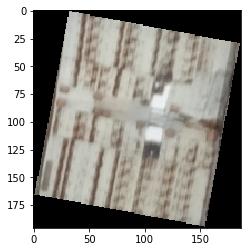

In [36]:
for p in model.parameters():
    if p.grad is not None:
        del p.grad
torch.cuda.empty_cache()

test_id = []
test_label = []
list_from_labelTensor = []

def test():
    model.eval()
    predictions = []
    for data, roof_id in test_loader:
        replaced_roof_id = roof_id[0]
        test_id.append(replaced_roof_id)
        print(replaced_roof_id)
        data = data.cuda(async=True) # On GPU
        output = model(data)
        list_from_labelTensor = torch.nn.functional.softmax(output, dim=1).tolist()
        print(replaced_roof_id, list_from_labelTensor)
        test_label.append(list_from_labelTensor)
        
        

test()
    

In [35]:
test_label

[]

In [ ]:
test_id

In [11]:
sub_format = open('./submission_format.csv', 'r')

In [40]:
f = open('./submission_result.csv', 'w', encoding = 'utf-8', newline = '')
wr = csv.writer(f)
wr.writerow(["id","concrete_cement","healthy_metal","incomplete","irregular_metal","other"])
for i in range(0, len(test_id)):
    wr.writerow([test_id[i], 
                 test_label[i][0][0], 
                 test_label[i][0][1], 
                 test_label[i][0][2], 
                 test_label[i][0][3],
                 test_label[i][0][4]])
f.close

<function TextIOWrapper.close()>

In [ ]:
i = 0
for concrete_cement_image in concrete_cement_images:
    img = Image.open(concrete_cement_image)
    trans = transforms.ToPILImage()
    trans1 = transforms.ToTensor()
    concrete_cement_images_tensors.append(trans1(img))
    if i == 5:
        plt.imshow(trans(trans1(img)))
        raise
    concrete_cement_types.append(concrete_cement_type)
    i+=1
    

In [ ]:
concrete_cement_types

In [ ]:
concrete_cement_types[10]

In [ ]:
for healthy_metal_image in healthy_metal_images:
    img = Image.open(healthy_metal_image)
    trans = transforms.ToPILImage()
    trans1 = transforms.ToTensor()
    healthy_metal_images_tensors.append(trans1(img))
    plt.imshow(trans(trans1(img)))
    healthy_metal_types.append(healthy_metal_type)

In [ ]:
for incomplete_image in incomplete_images:
    img = Image.open(incomplete_image)
    trans = transforms.ToPILImage()
    trans1 = transforms.ToTensor()
    incomplete_images_tensors.append(trans1(img))
    plt.imshow(trans(trans1(img)))
    incomplete_types.append(incomplete_type)

In [ ]:
for irregular_metal_image in irregular_metal_images:
    img = Image.open(irregular_metal_image)
    trans = transforms.ToPILImage()
    trans1 = transforms.ToTensor()
    irregular_metal_images_tensors.append(trans1(img))
    plt.imshow(trans(trans1(img)))
    irregular_metal_types.append(irregular_metal_type)

In [ ]:
for other_image in other_images:
    img = Image.open(other_image)
    trans = transforms.ToPILImage()
    trans1 = transforms.ToTensor()
    other_images_tensors.append(trans1(img))
    plt.imshow(trans(trans1(img)))
    other_types.append(other_type)

In [ ]:
for test_image in test_images:
    img = Image.open(test_image)
    trans = transforms.ToPILImage()
    trans1 = transforms.ToTensor()
    test_images_tensors.append(trans1(img))
    plt.imshow(trans(trans1(img)))

In [ ]:
class RoofDataset(Dataset):
    def __init__(self, image, image_type_list):
        self.image = image
        self.image_type_list = image_type_list
        
    def __len__(self):
        return len(self.image)
    
    def __getitem__(self, idx):
        material_type = self.image_type_list[idx]
        roof_image = self.image[idx]
        return roof_image, material_type
        
                                  

In [ ]:
images_tensors = concrete_cement_images_tensors + healthy_metal_images_tensors + incomplete_images_tensors +irregular_metal_images_tensors + other_images_tensors
images_types = concrete_cement_types + healthy_metal_types + incomplete_types + irregular_metal_types + other_types

In [ ]:
images_types[10]

In [ ]:
type(images_types)

In [ ]:
dataset_all_train = RoofDataset(images_tensors, images_types)

In [ ]:
datas  = DataLoader(dataset_all_train, batch_size = 1, shuffle = True)

In [ ]:
dataloaders = {'train' : torch.utils.data.DataLoader(dataset_all_train, batch_size = 1, shuffle = True)}

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 35):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs -1))
        print('-' * 10)
        #Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train' :
                model.train()
            else : 
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size()
                running_corrects += torch.sum(pred == labels.data)
                
#             if phase == 'train':
#                 scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
            
            
            

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 5)

num_ftrs = model_ft.conv1.out_features
model_ft.conv1 = nn.conv2d()

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

### from torch.utils.data import Dataset, DataLoader

#Load the boston Dataset, examine the data

boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston['target'] = boston_dataset.target
boston.head()

# Implement PyTorch DataLoader of the target dataset

class BostonDataset(Dataset):
    def __init__(self, feature_data, target_data):
        self.feature_data = torch.FloatTensor(feature_data.values.astype('float'))
        self.target_data = torch.FloatTensor(target_data.values.astype('float'))

    def __len__(self):
        return len(self.feature_data)

    def __getitem__(self, idx):
        target = self.target_data[idx]
        data = self.feature_data[idx]
        return data,target
      
dataset_all_train = BostonDataset(X_train, Y_train)
dataloader_all_train = DataLoader(dataset_all_train, batch_size=len(dataset_all_train), shuffle=True)
print(len(dataset_all_train))